# Frame the business problem into data science problem
#### The target value to predict here is the total seconds value between `created_at` and `actual_delivery_time`

In [ ]:
# !pip install category_encoders/catboost/shap/mlflow/colorama

In [ ]:
! pip install category_encoders

In [ ]:
! pip install catboost

In [ ]:
! pip install shap

In [ ]:
! pip install mlflow

In [ ]:
! pip install colorama

### Import library and packages

In [ ]:
import gc
import os
import sys
import itertools
import shutil
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import datetime
from datetime import datetime, time
from math import sqrt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import category_encoders

import pickle
import joblib

import sklearn
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import  OneHotEncoder

from sklearn.ensemble import RandomForestRegressor as rf

import catboost as cat
from catboost import Pool, cv
from catboost import CatBoostRegressor
import shap

import xgboost 
from xgboost import XGBRegressor

import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import colorama

import matplotlib.pyplot as plt 


import seaborn as sns


#ignore warnings
import warnings
warnings.filterwarnings('ignore')


print(pd.__version__)
print(np.__version__)
print(cat.__version__)
print(sns.__version__)
print(sklearn.__version__)
print(xgboost.__version__)
print(sm.__version__)
print(category_encoders.__version__)


import mlflow
import mlflow.pyfunc
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env
import cloudpickle

1.3.5
1.21.5
1.0.5
0.11.2
1.0.2
0.90
0.10.2
2.4.0


### 1. Data exploration analysis

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# read in data, parse date for sure
historical_data = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/historical_data.csv",  parse_dates=['created_at', 'actual_delivery_time'])

In [ ]:
# basic descriptive analysis to get the general idea of the dataframe: there are null values in both categorical and numeric columns
print(historical_data.shape)
print(historical_data.columns)
print(historical_data.info())
print(historical_data.isnull().sum())
historical_data.describe()

(197428, 9)
Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'subtotal', 'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 9 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     196441 non-null  float64       
 1   created_at                                    197428 non-null  datetime64[ns]
 2   actual_delivery_time                          197421 non-null  datetime64[ns]
 3   store_id                                      197428 non-null  int64         
 4   subtotal                                      197428 non-null  int64         
 5   total_onshift_dashers                      

market_id       store_id       subtotal  total_onshift_dashers  \
count  196441.000000  197428.000000  197428.000000          181166.000000   
mean        2.978706    3530.510272    2682.331402              44.808093   
std         1.524867    2053.496711    1823.093688              34.526783   
min         1.000000       1.000000       0.000000              -4.000000   
25%         2.000000    1686.000000    1400.000000              17.000000   
50%         3.000000    3592.000000    2200.000000              37.000000   
75%         4.000000    5299.000000    3395.000000              65.000000   
max         6.000000    6987.000000   27100.000000             171.000000   

       total_busy_dashers  total_outstanding_orders  \
count       181166.000000             181166.000000   
mean            41.739747                 58.050065   
std             32.145733                 52.661830   
min             -5.000000                 -6.000000   
25%             15.000000                 17.000000   
50%             34.000000                 41.000000   
75%             62.000000                 85.000000   
max            154.000000                285.000000   

       estimated_store_to_consumer_driving_duration  
count                                 196902.000000  
mean                                     545.358935  
std                                      219.352902  
min                                        0.000000  
25%                                      382.000000  
50%                                      544.000000  
75%                                      702.000000  
max                                     2088.000000

In [ ]:
# see if there is any feature stores lots of Zeros: looks fine
def feature_zero_ratio(df_in):
    ratio = ((df_in == 0).sum(axis=0)) / df_in.notnull().sum()
    percentage_zero = pd.DataFrame(ratio).reset_index().rename(columns={'index': 'feature', 0: 'zero_ratio'})
    return percentage_zero
feature_zero_ratio(historical_data)

feature  zero_ratio
0                                     market_id    0.000000
1                                    created_at    0.000000
2                          actual_delivery_time    0.000000
3                                      store_id    0.000000
4                                      subtotal    0.000907
5                         total_onshift_dashers    0.019954
6                            total_busy_dashers    0.023023
7                      total_outstanding_orders    0.022692
8  estimated_store_to_consumer_driving_duration    0.000046

In [ ]:
# take a look of the data to have a visual impression
historical_data.head(5)

market_id          created_at actual_delivery_time  store_id  subtotal  \
0        1.0 2015-02-06 22:24:17  2015-02-06 23:27:16      1845      3441   
1        2.0 2015-02-10 21:49:25  2015-02-10 22:56:29      5477      1900   
2        3.0 2015-01-22 20:39:28  2015-01-22 21:09:09      5477      1900   
3        3.0 2015-02-03 21:21:45  2015-02-03 22:13:00      5477      6900   
4        3.0 2015-02-15 02:40:36  2015-02-15 03:20:26      5477      3900   

   total_onshift_dashers  total_busy_dashers  total_outstanding_orders  \
0                   33.0                14.0                      21.0   
1                    1.0                 2.0                       2.0   
2                    1.0                 0.0                       0.0   
3                    1.0                 1.0                       2.0   
4                    6.0                 6.0                       9.0   

   estimated_store_to_consumer_driving_duration  
0                                         861.0  
1                                         690.0  
2                                         690.0  
3                                         289.0  
4                                         650.0

In [ ]:
# percentage of missing is low for each features: e.g., 16262/197428  = 8.2%
# drop rows with null. 
historical_data.dropna(inplace=True)

In [ ]:
# In data descriptive analysis, I found there are negative values in ['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders']
# These cases is against common sense, assume they are error data. therefore removed. 
def remove_negative(df):
    negative_col = ['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders']
    for col in negative_col:
        df.drop(df[df[col] < 0].index, inplace=True)
    return df 

remove_negative(historical_data)

market_id          created_at actual_delivery_time  store_id  \
0             1.0 2015-02-06 22:24:17  2015-02-06 23:27:16      1845   
1             2.0 2015-02-10 21:49:25  2015-02-10 22:56:29      5477   
2             3.0 2015-01-22 20:39:28  2015-01-22 21:09:09      5477   
3             3.0 2015-02-03 21:21:45  2015-02-03 22:13:00      5477   
4             3.0 2015-02-15 02:40:36  2015-02-15 03:20:26      5477   
...           ...                 ...                  ...       ...   
197423        1.0 2015-02-17 00:19:41  2015-02-17 01:24:48      2956   
197424        1.0 2015-02-13 00:01:59  2015-02-13 00:58:22      2956   
197425        1.0 2015-01-24 04:46:08  2015-01-24 05:36:16      2956   
197426        1.0 2015-02-01 18:18:15  2015-02-01 19:23:22      3630   
197427        1.0 2015-02-08 19:24:33  2015-02-08 20:01:41      3630   

        subtotal  total_onshift_dashers  total_busy_dashers  \
0           3441                   33.0                14.0   
1           1900                    1.0                 2.0   
2           1900                    1.0                 0.0   
3           6900                    1.0                 1.0   
4           3900                    6.0                 6.0   
...          ...                    ...                 ...   
197423      1389                   17.0                17.0   
197424      3010                   12.0                11.0   
197425      1836                   39.0                41.0   
197426      1175                    7.0                 7.0   
197427      2605                   20.0                20.0   

        total_outstanding_orders  estimated_store_to_consumer_driving_duration  
0                           21.0                                         861.0  
1                            2.0                                         690.0  
2                            0.0                                         690.0  
3                            2.0                                         289.0  
4                            9.0                                         650.0  
...                          ...                                           ...  
197423                      23.0                                         331.0  
197424                      14.0                                         915.0  
197425                      40.0                                         795.0  
197426                      12.0                                         384.0  
197427                      23.0                                         134.0  

[179679 rows x 9 columns]

In [ ]:
# Early feature engineering
# Some columns can be combined to generate more informative columns.

historical_data['actual_total_delivery_duration_seconds']  = historical_data['actual_delivery_time'] - historical_data['created_at'] 
historical_data['actual_total_delivery_duration_seconds'] = historical_data['actual_total_delivery_duration_seconds'].dt.total_seconds()
historical_data['total_available_dasher']  = historical_data['total_onshift_dashers'] - historical_data['total_busy_dashers'] 


In [ ]:
historical_data.describe(include = 'all')
# I found "total_available_dasher" has negative number, need to clean the data further

market_id           created_at actual_delivery_time  \
count   179679.000000               179679               179679   
unique            NaN               165931               163515   
top               NaN  2015-02-11 19:50:43  2015-02-01 03:44:13   
freq              NaN                    6                    5   
first             NaN  2015-01-21 15:22:03  2015-01-21 15:58:11   
last              NaN  2015-02-18 06:00:44  2015-02-19 22:45:31   
mean         2.749002                  NaN                  NaN   
std          1.331733                  NaN                  NaN   
min          1.000000                  NaN                  NaN   
25%          2.000000                  NaN                  NaN   
50%          2.000000                  NaN                  NaN   
75%          4.000000                  NaN                  NaN   
max          6.000000                  NaN                  NaN   

             store_id       subtotal  total_onshift_dashers  \
count   179679.000000  179679.000000          179679.000000   
unique            NaN            NaN                    NaN   
top               NaN            NaN                    NaN   
freq              NaN            NaN                    NaN   
first             NaN            NaN                    NaN   
last              NaN            NaN                    NaN   
mean      3545.134935    2699.277361              44.837716   
std       2057.690402    1829.262696              34.539170   
min          1.000000       0.000000               0.000000   
25%       1686.000000    1417.000000              17.000000   
50%       3614.000000    2225.000000              37.000000   
75%       5323.000000    3415.000000              65.000000   
max       6987.000000   26800.000000             171.000000   

        total_busy_dashers  total_outstanding_orders  \
count        179679.000000             179679.000000   
unique                 NaN                       NaN   
top                    NaN                       NaN   
freq                   NaN                       NaN   
first                  NaN                       NaN   
last                   NaN                       NaN   
mean             41.770875                 58.092482   
std              32.157300                 52.682209   
min               0.000000                  0.000000   
25%              15.000000                 17.000000   
50%              34.000000                 41.000000   
75%              62.000000                 85.000000   
max             154.000000                285.000000   

        estimated_store_to_consumer_driving_duration  \
count                                  179679.000000   
unique                                           NaN   
top                                              NaN   
freq                                             NaN   
first                                            NaN   
last                                             NaN   
mean                                      545.885140   
std                                       218.573212   
min                                         0.000000   
25%                                       383.000000   
50%                                       544.000000   
75%                                       703.000000   
max                                      2088.000000   

        actual_total_delivery_duration_seconds  total_available_dasher  
count                            179679.000000           179679.000000  
unique                                     NaN                     NaN  
top                                        NaN                     NaN  
freq                                       NaN                     NaN  
first                                      NaN                     NaN  
last                                       NaN                     NaN  
mean                               2866.652881                3.066841  
std                                1

In [ ]:
# remove negative values in  "total_available_dasher" for both historical_data and historical_data_0

historical_data.drop(historical_data[historical_data['total_available_dasher'] < 0].index, inplace=True)


In [ ]:
# double check data, no more negative values that do not make sense
# however, I found some extreme value indicating potential outliers: 
# for example, actual_total_delivery_duration_seconds = 373,879 about 104 hours which does not make sense unless it is some pre-order of food/grocery delivery
historical_data.describe(include = 'all')

market_id           created_at actual_delivery_time  \
count   139596.000000               139596               139596   
unique            NaN               129976               128463   
top               NaN  2015-02-11 19:50:43  2015-02-11 20:40:45   
freq              NaN                    6                    5   
first             NaN  2015-01-21 15:22:03  2015-01-21 15:58:11   
last              NaN  2015-02-18 06:00:44  2015-02-19 22:45:31   
mean         2.815969                  NaN                  NaN   
std          1.337553                  NaN                  NaN   
min          1.000000                  NaN                  NaN   
25%          2.000000                  NaN                  NaN   
50%          3.000000                  NaN                  NaN   
75%          4.000000                  NaN                  NaN   
max          6.000000                  NaN                  NaN   

             store_id       subtotal  total_onshift_dashers  \
count   139596.000000  139596.000000          139596.000000   
unique            NaN            NaN                    NaN   
top               NaN            NaN                    NaN   
freq              NaN            NaN                    NaN   
first             NaN            NaN                    NaN   
last              NaN            NaN                    NaN   
mean      3555.527909    2712.490508              45.996998   
std       2054.724988    1845.388469              36.085763   
min          1.000000       0.000000               0.000000   
25%       1703.000000    1414.000000              17.000000   
50%       3620.000000    2237.000000              37.000000   
75%       5336.000000    3445.000000              68.000000   
max       6987.000000   22500.000000             171.000000   

        total_busy_dashers  total_outstanding_orders  \
count        139596.000000             139596.000000   
unique                 NaN                       NaN   
top                    NaN                       NaN   
freq                   NaN                       NaN   
first                  NaN                       NaN   
last                   NaN                       NaN   
mean             39.755724                 58.021054   
std              31.685592                 54.334285   
min               0.000000                  0.000000   
25%              13.000000                 15.000000   
50%              32.000000                 39.000000   
75%              60.000000                 87.000000   
max             148.000000                285.000000   

        estimated_store_to_consumer_driving_duration  \
count                                  139596.000000   
unique                                           NaN   
top                                              NaN   
freq                                             NaN   
first                                            NaN   
last                                             NaN   
mean                                      545.717850   
std                                       219.004709   
min                                         0.000000   
25%                                       383.000000   
50%                                       543.000000   
75%                                       702.000000   
max                                      1711.000000   

        actual_total_delivery_duration_seconds  total_available_dasher  
count                            139596.000000           139596.000000  
unique                                     NaN                     NaN  
top                                        NaN                     NaN  
freq                                       NaN                     NaN  
first                                      NaN                     NaN  
last                                       NaN                     NaN  
mean                               2842.975809                6.241275  
std                                1

In [ ]:
historical_data.duplicated().sum()
# no duplcaite row

0

In [ ]:
# I find the row with extreme value and I want to see if this is normal for this market and this store with a payment subtotal as $ 15.2 (guess it is fastfood).
# if it is fastfood, it should not be 104 hours, no one will wait that long for "fastfood"
historical_data[historical_data['actual_total_delivery_duration_seconds'] == 373879.0]

market_id          created_at actual_delivery_time  store_id  \
185550        4.0 2015-01-28 08:34:06  2015-02-01 16:25:25      6503   

        subtotal  total_onshift_dashers  total_busy_dashers  \
185550      1520                    0.0                 0.0   

        total_outstanding_orders  \
185550                       0.0   

        estimated_store_to_consumer_driving_duration  \
185550                                         476.0   

        actual_total_delivery_duration_seconds  total_available_dasher  
185550                                373879.0                     0.0

In [ ]:
# query the data,I proved that I was correct. In same store with same payment, actual_total_delivery_duration_seconds should not vary too much. not like 104 hours that long. 
# so it should be considered as an outlier. As Jared shared with me, in this case we targets 30-45 min delivery time.
historical_data.query("(market_id==4)&(store_id==6503)&(subtotal ==1520)")

market_id          created_at actual_delivery_time  store_id  \
185494        4.0 2015-02-07 17:48:49  2015-02-07 18:50:04      6503   
185536        4.0 2015-02-08 18:12:44  2015-02-08 18:39:20      6503   
185550        4.0 2015-01-28 08:34:06  2015-02-01 16:25:25      6503   
185601        4.0 2015-02-15 17:28:57  2015-02-15 17:50:56      6503   

        subtotal  total_onshift_dashers  total_busy_dashers  \
185494      1520                    8.0                 7.0   
185536      1520                    8.0                 8.0   
185550      1520                    0.0                 0.0   
185601      1520                   13.0                11.0   

        total_outstanding_orders  \
185494                      11.0   
185536                      11.0   
185550                       0.0   
185601                      10.0   

        estimated_store_to_consumer_driving_duration  \
185494                                         202.0   
185536                                         202.0   
185550                                         476.0   
185601                                         209.0   

        actual_total_delivery_duration_seconds  total_available_dasher  
185494                                  3675.0                     1.0  
185536                                  1596.0                     0.0  
185550                                373879.0                     0.0  
185601                                  1319.0                     2.0

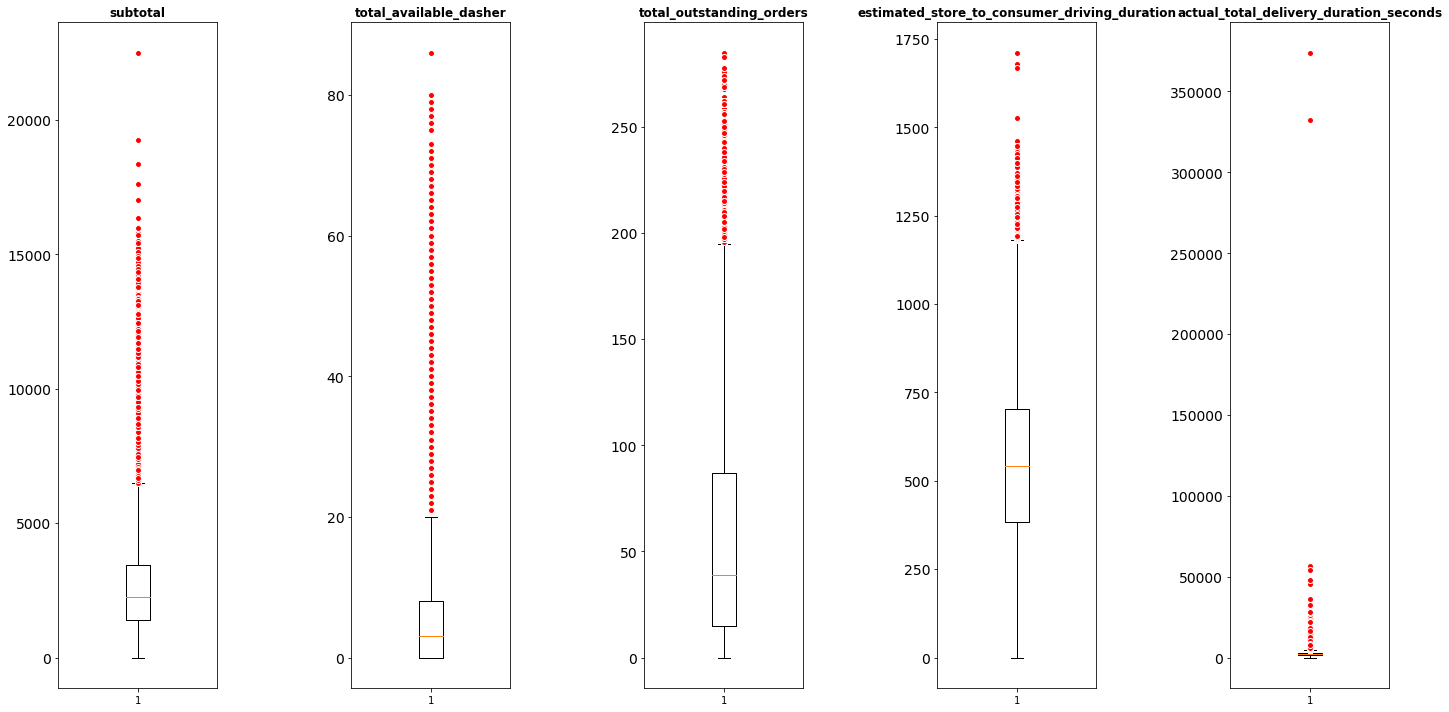

In [ ]:
# review data for outlier: we can see that there are many potential outliers, especially for "actual_total_delivery_duration_seconds"
check_outlier = historical_data[['subtotal','total_available_dasher',
       'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration',
       'actual_total_delivery_duration_seconds']]

def box_plot(df):
    red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')
    fig, axs = plt.subplots(1, len(df.columns), figsize=(20,10))
    for i, ax in enumerate(axs.flat):
        ax.boxplot(df.iloc[:,i], flierprops=red_circle)
        ax.set_title(df.columns[i], fontsize=12, fontweight='bold')
        ax.tick_params(axis='y', labelsize=14)
    return plt.tight_layout()

box_plot(check_outlier)

In [ ]:
# update historical_data with informative columns
historical_data = historical_data[['market_id', 'store_id', 'created_at',
       'subtotal', 'total_available_dasher',
       'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration',
       'actual_total_delivery_duration_seconds']]

In [ ]:
# drop outlier using IQR
def drop_outlier(df):
    outlier_cols = ['subtotal', 'total_available_dasher', 'total_outstanding_orders', 'estimated_store_to_consumer_driving_duration', 'actual_total_delivery_duration_seconds']
    for col in outlier_cols:
        Q1 = np.percentile(df[col], 25, interpolation = 'midpoint')
        Q3 = np.percentile(df[col], 75, interpolation = 'midpoint')
        IQR = Q3 - Q1
        print(f'For {col}, Q1 is {Q1}, Q3 is {Q3}, IQR is {IQR}.')
        
        print(f"{df} shape before removing outlier: {df.shape}.")
        
        # Upper bound
        upper = Q3+1.5*IQR
        # Lower bound
        lower = Q1-1.5*IQR
        print(f'For {col}, Upper bound is {upper}, Lower bound is {lower}')
        
        ''' Removing the Outliers '''
        df.drop(df[df[col] > upper].index, inplace=True)
        df.drop(df[df[col] < lower].index, inplace=True)
        
        print(f"{df} shape after removing outlier: {df.shape}.")
    return df

drop_outlier(historical_data)

For subtotal, Q1 is 1414.0, Q3 is 3445.0, IQR is 2031.0.
        market_id  store_id          created_at  subtotal  \
0             1.0      1845 2015-02-06 22:24:17      3441   
2             3.0      5477 2015-01-22 20:39:28      1900   
3             3.0      5477 2015-02-03 21:21:45      6900   
4             3.0      5477 2015-02-15 02:40:36      3900   
5             3.0      5477 2015-01-28 20:30:38      5000   
...           ...       ...                 ...       ...   
197420        2.0      2956 2015-02-18 02:16:04      2352   
197423        1.0      2956 2015-02-17 00:19:41      1389   
197424        1.0      2956 2015-02-13 00:01:59      3010   
197426        1.0      3630 2015-02-01 18:18:15      1175   
197427        1.0      3630 2015-02-08 19:24:33      2605   

        total_available_dasher  total_outstanding_orders  \
0                         19.0                      21.0   
2                          1.0                       0.0   
3                          0.0

market_id  store_id          created_at  subtotal  \
0             1.0      1845 2015-02-06 22:24:17      3441   
2             3.0      5477 2015-01-22 20:39:28      1900   
4             3.0      5477 2015-02-15 02:40:36      3900   
5             3.0      5477 2015-01-28 20:30:38      5000   
6             3.0      5477 2015-01-31 02:16:36      3900   
...           ...       ...                 ...       ...   
197420        2.0      2956 2015-02-18 02:16:04      2352   
197423        1.0      2956 2015-02-17 00:19:41      1389   
197424        1.0      2956 2015-02-13 00:01:59      3010   
197426        1.0      3630 2015-02-01 18:18:15      1175   
197427        1.0      3630 2015-02-08 19:24:33      2605   

        total_available_dasher  total_outstanding_orders  \
0                         19.0                      21.0   
2                          1.0                       0.0   
4                          0.0                       9.0   
5                          0.0                       2.0   
6                          1.0                       9.0   
...                        ...                       ...   
197420                     0.0                      65.0   
197423                     0.0                      23.0   
197424                     1.0                      14.0   
197426                     0.0                      12.0   
197427                     0.0                      23.0   

        estimated_store_to_consumer_driving_duration  \
0                                              861.0   
2                                              690.0   
4                                              650.0   
5                                              338.0   
6                                              638.0   
...                                              ...   
197420                                         560.0   
197423                                         331.0   
197424                                         915.0   
197426                                         384.0   
197427                                         134.0   

        actual_total_delivery_duration_seconds  
0                                       3779.0  
2                                       1781.0  
4                                       2390.0  
5                                       2300.0  
6                                       1584.0  
...                                        ...  
197420                                  3392.0  
197423                                  3907.0  
197424                                  3383.0  
197426                                  3907.0  
197427                                  2228.0  

[114197 rows x 8 columns]

In [ ]:
historical_data.describe()

market_id       store_id       subtotal  total_available_dasher  \
count  114197.000000  114197.000000  114197.000000           114197.000000   
mean        2.816046    3568.366603    2388.793839                4.129820   
std         1.364595    2059.195037    1318.014344                4.839472   
min         1.000000       1.000000       0.000000                0.000000   
25%         2.000000    1713.000000    1350.000000                0.000000   
50%         3.000000    3623.000000    2097.000000                2.000000   
75%         4.000000    5361.000000    3150.000000                6.000000   
max         6.000000    6987.000000    6490.000000               20.000000   

       total_outstanding_orders  estimated_store_to_consumer_driving_duration  \
count             114197.000000                                 114197.000000   
mean                  46.311961                                    539.513166   
std                   41.841799                                    216.921660   
min                    0.000000                                      0.000000   
25%                   13.000000                                    377.000000   
50%                   32.000000                                    537.000000   
75%                   69.000000                                    696.000000   
max                  171.000000                                   1181.000000   

       actual_total_delivery_duration_seconds  
count                           114197.000000  
mean                              2656.033687  
std                                848.727082  
min                                297.000000  
25%                               2030.000000  
50%                               2542.000000  
75%                               3180.000000  
max                               5102.000000

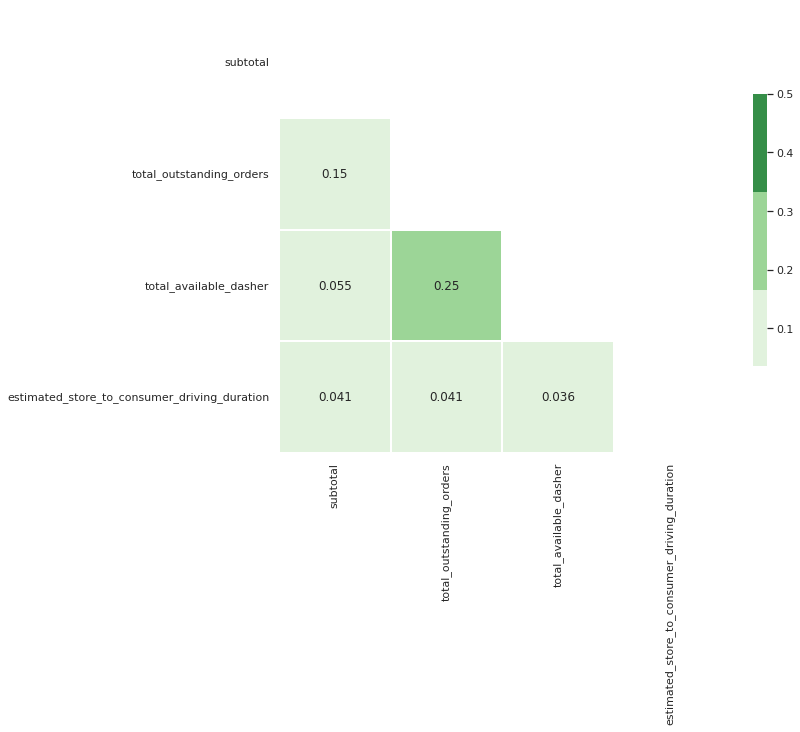

In [ ]:
# check correlations among features
def Diagonal_correlation_matrix(df):
    sns.set_theme(style="white")
    corr = df.corr()
    mask = np.triu(df.corr())
    f, ax = plt.subplots(figsize=(10, 10))
    cmap = sns.color_palette("PRGn")

    return sns.heatmap(corr, 
                mask=mask, 
                cmap=cmap, 
                vmax=.5, 
                center=0,
                square=True,
                annot = True,
                linewidths=1, 
                cbar_kws={"shrink": .5}
               )
Diagonal_correlation_matrix(historical_data[['subtotal', 'total_outstanding_orders', 'total_available_dasher',
       'estimated_store_to_consumer_driving_duration']])

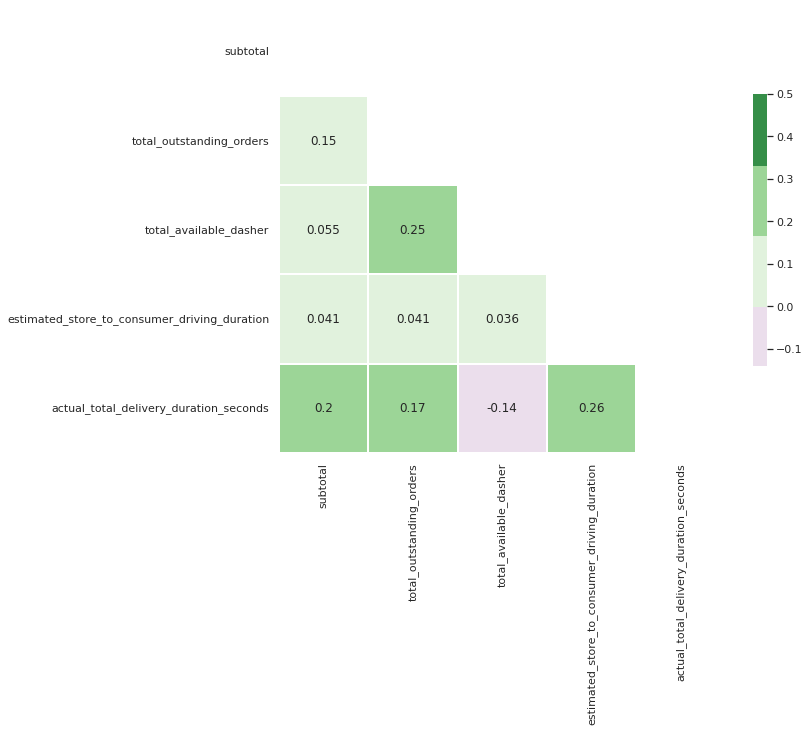

In [ ]:
# check correlations among features and target
def Diagonal_correlation_matrix(df):
    sns.set_theme(style="white")
    corr = df.corr()
    mask = np.triu(df.corr())
    f, ax = plt.subplots(figsize=(10, 10))
    cmap = sns.color_palette("PRGn")

    return sns.heatmap(corr, 
                mask=mask, 
                cmap=cmap, 
                vmax=.5, 
                center=0,
                square=True,
                annot = True,
                linewidths=1, 
                cbar_kws={"shrink": .5}
               )
Diagonal_correlation_matrix(historical_data[['subtotal', 'total_outstanding_orders', 'total_available_dasher',
       'estimated_store_to_consumer_driving_duration',
       'actual_total_delivery_duration_seconds']])

In [ ]:
# check collinearity using VIF, VIF<10 indicate no collinearity (only for numeric variables), just for a quick linear regression test

# Assumptions for Simple Linear Regression For reference
# 1.Linearity: The relationship between  X and y must be linear.
# 2.Independence of errors: There is not a relationship between the residuals and the y variable; in other words, y is independent of errors.
# 3.Normality of errors: The residuals must be approximately normally distributed.
# 4.Equal variances: The variance of the residuals is the same for all values of X.


def vif(df):  
    y, X = dmatrices('actual_total_delivery_duration_seconds ~ subtotal+total_outstanding_orders+total_available_dasher+estimated_store_to_consumer_driving_duration', data=df, return_type='dataframe')
    vif = pd.DataFrame()
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['variable'] = X.columns
    return vif
vif(historical_data[['subtotal', 'total_outstanding_orders', 'total_available_dasher',
       'estimated_store_to_consumer_driving_duration',
       'actual_total_delivery_duration_seconds']])

# no collinearity as expected

VIF                                      variable
0  10.952580                                     Intercept
1   1.023923                                      subtotal
2   1.089707                      total_outstanding_orders
3   1.069081                        total_available_dasher
4   1.003558  estimated_store_to_consumer_driving_duration

In [ ]:
# quick test using sklearn linear regression for exlporation purpose: only use numeric variables

#Setting the value for X and y
X = historical_data[['subtotal', 'total_outstanding_orders', 'total_available_dasher',
       'estimated_store_to_consumer_driving_duration']]
y = historical_data['actual_total_delivery_duration_seconds']
#Splitting the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 100)
#Fitting the Multiple Linear Regression model
mlr = LinearRegression()  
mlr.fit(X_train, y_train)
#Intercept and Coefficient
print("Intercept: ", mlr.intercept_)
print(f"Coefficients: {list(zip(X, mlr.coef_))}")
#Prediction of test set
y_pred_mlr= mlr.predict(X_test)
#Predicted values
# print("Prediction for test set: {}".format(y_pred_mlr))
#Actual value and the predicted value
mlr_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred_mlr})
mlr_diff.head()
#Model Evaluation
from sklearn import metrics
meanAbErr = metrics.mean_absolute_error(y_test, y_pred_mlr)
meanSqErr = metrics.mean_squared_error(y_test, y_pred_mlr)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_mlr))
print('R squared: {:.2f}'.format(mlr.score(X,y)*100))
print('Mean Absolute Error:', meanAbErr)
print('Mean Square Error:', meanSqErr)
print('Root Mean Square Error:', rootMeanSqErr)

Intercept:  1818.3100406925137
Coefficients: [('subtotal', 0.11482690997660062), ('total_outstanding_orders', 3.8290318720222425), ('total_available_dasher', -35.8876091955102), ('estimated_store_to_consumer_driving_duration', 0.9906435695058677)]
R squared: 16.44
Mean Absolute Error: 620.215064402093
Mean Square Error: 603469.4367229592
Root Mean Square Error: 776.8329529074826


In [ ]:
# quick test using statsmodels linear regression for exlporation purpose: only use numeric variables

OLSmodel = sm.OLS(historical_data['actual_total_delivery_duration_seconds'], 
                  historical_data[['subtotal', 'total_outstanding_orders', 'total_available_dasher','estimated_store_to_consumer_driving_duration']] ).fit() 
print(OLSmodel.summary())

                                           OLS Regression Results                                          
Dep. Variable:     actual_total_delivery_duration_seconds   R-squared (uncentered):                   0.884
Model:                                                OLS   Adj. R-squared (uncentered):              0.884
Method:                                     Least Squares   F-statistic:                          2.170e+05
Date:                                    Wed, 13 Apr 2022   Prob (F-statistic):                        0.00
Time:                                            13:05:43   Log-Likelihood:                     -9.4512e+05
No. Observations:                                  114197   AIC:                                  1.890e+06
Df Residuals:                                      114193   BIC:                                  1.890e+06
Df Model:                                               4                                                  
Covariance Type:            

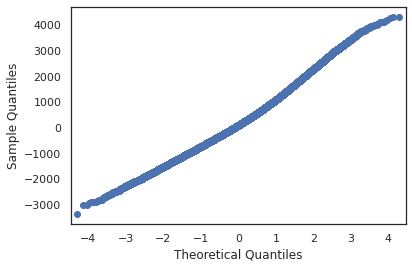

In [ ]:
residual = OLSmodel.resid
fig = sm.qqplot(residual)
plt.show()

### 2. Feature engineering

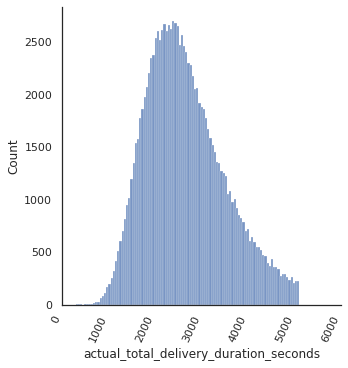

In [ ]:
# check target distribution: right skewed as expected 
sns.displot(historical_data['actual_total_delivery_duration_seconds']).set_xticklabels(rotation=65, horizontalalignment='right')

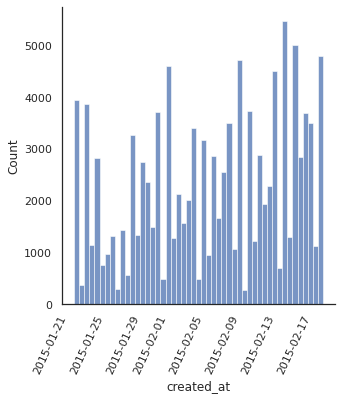

In [ ]:
# start feature engineering by checking categrical variables: created_at is a date time value indicate when the order was made
# this feature may indicate the traffic or order volumn in different time of the day or different day (holiday vs weekend vs weekdays)
# for example, Valentine's day may have more orders
sns.displot(historical_data['created_at']).set_xticklabels(rotation=65, horizontalalignment='right')

In [ ]:
# change "create_at" to 5 different time period of the day to reflect the traffic or order volumn
# new feature "time_cat" (time catgeory) was created 

def create_at_time_categories(row):
    time_cats = {'morning':(time(5,0,0), time(11,59,59)), 'afternoon':(time(12,0,0), time(16,59,59)),
                 'evening':(time(17,0,0), time(20,59,59)), 'night (PM)':(time(21,0,0), time(23,59,59)), 
                 'night (AM)':(time(0,0,0), time(4,59,59))}
    for k, v in time_cats.items():
        if v[0] <= row['created_at'].time() <= v[1]:
            row['time_cat'] = k
    return row

In [ ]:
# apply my function
historical_data = historical_data.apply(create_at_time_categories, axis = "columns")

In [ ]:
# double check the output
historical_data['time_cat'].unique()

array(['night (PM)', 'evening', 'night (AM)', 'morning', 'afternoon'],
      dtype=object)

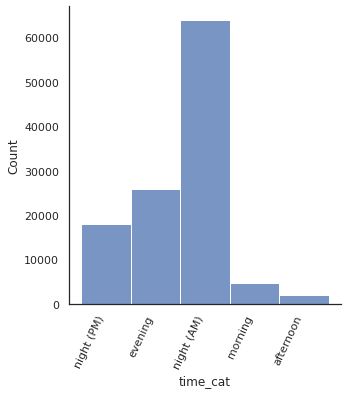

In [ ]:
# interestingly found night (AM) <0:00 AM to 4:59 AM has the most orders>
sns.displot(historical_data['time_cat']).set_xticklabels(rotation=65, horizontalalignment='right')

In [ ]:
# update historical_data columns
historical_data = historical_data[['market_id', 'store_id','time_cat', 'subtotal',
       'total_available_dasher', 'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration',
       'actual_total_delivery_duration_seconds']]

In [ ]:
# there are 6 market_id indicating 6 different cities
historical_data.market_id.unique()

array([1., 3., 2., 4., 5., 6.])

In [ ]:
# each market has different number of stores 
market_store_counts = historical_data[['market_id','store_id']].groupby(['market_id'])['store_id'].nunique()
market_store_counts

market_id
1.0    2522
2.0    1511
3.0    2069
4.0    1427
5.0    1140
6.0     376
Name: store_id, dtype: int64

In [ ]:
# each market has different order numbers
market_order_counts = historical_data.groupby(['market_id']).size().reset_index(name='market_order_counts')
market_order_counts

market_id  market_order_counts
0        1.0                24476
1        2.0                30070
2        3.0                16471
3        4.0                28771
4        5.0                13983
5        6.0                  426

In [ ]:
# each time period has different order numbers
time_period_order_counts = historical_data.groupby(['time_cat']).size().reset_index(name='time_period_order_counts')
time_period_order_counts

time_cat  time_period_order_counts
0   afternoon                      2001
1     evening                     25769
2     morning                      4603
3  night (AM)                     63811
4  night (PM)                     18013

In [ ]:
# keep historical_data and use historical_data_0
historical_data_0 = historical_data.copy()


# different market means different cities, different cities has different patterns for delivery, so one-hot encoding market_id
# similarly different time period has different patterns, one-hot encoding time_cat
# one hot encoding market_id and time_cat
historical_data_0 = pd.get_dummies(historical_data_0, columns=['market_id', 'time_cat'])
historical_data_0.columns

Index(['store_id', 'subtotal', 'total_available_dasher',
       'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration',
       'actual_total_delivery_duration_seconds', 'market_id_1.0',
       'market_id_2.0', 'market_id_3.0', 'market_id_4.0', 'market_id_5.0',
       'market_id_6.0', 'time_cat_afternoon', 'time_cat_evening',
       'time_cat_morning', 'time_cat_night (AM)', 'time_cat_night (PM)'],
      dtype='object')

In [ ]:
# there are 5632 stores in current data (historical_data_0)
historical_data_0.store_id.nunique()

5632

In [ ]:
# different stores has different patterns 
# first create a new store_id_new feature to make each value a string
# then apply target encoding with catboost encoding to store_id 
historical_data_0['store_id_new'] ='store' + historical_data_0['store_id'].astype(str)
historical_data_0 = historical_data_0[['store_id_new', 
       'subtotal', 'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration',
        'total_available_dasher', 'market_id_1.0',
       'market_id_2.0', 'market_id_3.0', 'market_id_4.0', 'market_id_5.0',
       'market_id_6.0', 'time_cat_afternoon', 'time_cat_evening',
       'time_cat_morning', 'time_cat_night (AM)', 'time_cat_night (PM)',
        'actual_total_delivery_duration_seconds']]
target = historical_data_0[['actual_total_delivery_duration_seconds']]
train = historical_data_0.drop('actual_total_delivery_duration_seconds', axis = 1)
  
# Define catboost encoder
cbe_encoder = category_encoders.cat_boost.CatBoostEncoder()
  
# Fit encoder and transform the features
cbe_encoder.fit(train, target)
train_cbe = cbe_encoder.transform(train)

### 3. Modeling

In [ ]:
# train_test_split
X = train_cbe[['store_id_new', 'subtotal', 'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration',
       'total_available_dasher', 
       'market_id_1.0', 'market_id_2.0', 'market_id_3.0', 'market_id_4.0',
       'market_id_5.0', 'market_id_6.0', 'time_cat_afternoon',
       'time_cat_evening', 'time_cat_morning', 'time_cat_night (AM)',
       'time_cat_night (PM)']]


y = historical_data_0['actual_total_delivery_duration_seconds']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### 3.0 linear regression

In [ ]:
# quick test using sklearn linear regression

#Fitting the Multiple Linear Regression model
mlr = LinearRegression()  
mlr.fit(X_train, y_train)
#Intercept and Coefficient
print("Intercept: ", mlr.intercept_)
print(f"Coefficients: {list(zip(X, mlr.coef_))}")
#Prediction of test set
y_pred_mlr= mlr.predict(X_test)
#Predicted values
# print("Prediction for test set: {}".format(y_pred_mlr))
#Actual value and the predicted value
mlr_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred_mlr})
mlr_diff.head()
#Model Evaluation
from sklearn import metrics
meanAbErr = metrics.mean_absolute_error(y_test, y_pred_mlr)
meanSqErr = metrics.mean_squared_error(y_test, y_pred_mlr)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_mlr))
print('R squared: {:.2f}'.format(mlr.score(X,y)*100))
print('Mean Absolute Error:', meanAbErr)
print('Mean Square Error:', meanSqErr)
print('Root Mean Square Error:', rootMeanSqErr)

Intercept:  -515.570529128584
Coefficients: [('store_id_new', 0.9253176454309653), ('subtotal', 0.06163276950007465), ('total_outstanding_orders', 5.115855730240193), ('estimated_store_to_consumer_driving_duration', 0.880405368229455), ('total_available_dasher', -28.764158605981464), ('market_id_1.0', 54.15030995415586), ('market_id_2.0', -119.74510922780206), ('market_id_3.0', 82.05513827227331), ('market_id_4.0', -120.48748449360703), ('market_id_5.0', 116.85076747731256), ('market_id_6.0', -12.82362198233304), ('time_cat_afternoon', 304.621733272708), ('time_cat_evening', -6.860854294604777), ('time_cat_morning', -236.45216572667576), ('time_cat_night (AM)', 37.337931643995034), ('time_cat_night (PM)', -98.64664489542213)]
R squared: 32.74
Mean Absolute Error: 547.2163152538482
Mean Square Error: 481484.19935113034
Root Mean Square Error: 693.8906249194683


In [ ]:
# quick test using statsmodels linear regression 

OLSmodel = sm.OLS(y_train,  X_train).fit() 
print(OLSmodel.summary())

                                      OLS Regression Results                                      
Dep. Variable:     actual_total_delivery_duration_seconds   R-squared:                       0.328
Model:                                                OLS   Adj. R-squared:                  0.327
Method:                                     Least Squares   F-statistic:                     2980.
Date:                                    Wed, 13 Apr 2022   Prob (F-statistic):               0.00
Time:                                            13:08:49   Log-Likelihood:            -6.8221e+05
No. Observations:                                   85647   AIC:                         1.364e+06
Df Residuals:                                       85632   BIC:                         1.365e+06
Df Model:                                              14                                         
Covariance Type:                                nonrobust                                         
          

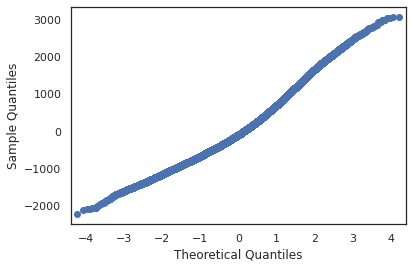

In [ ]:
residual = OLSmodel.resid
fig = sm.qqplot(residual)
plt.show()

#### 3.1 Catboost regressor (grid search and use best model)

In [ ]:
# why I choose Catboost

## Ordered Boosting is the key

In [ ]:
# Grid search best parameter
CBR = CatBoostRegressor()
parameters = {'depth'         : [2,4,6,8],
             'learning_rate' : [0.01,0.05,0.1,0.5],
              'iterations'    : [50,100,300,500,800,1000]
             }
Grid_CBR = GridSearchCV(estimator=CBR, param_grid = parameters, cv = 3, n_jobs=2)
Grid_CBR.fit(X_train, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_CBR.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBR.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBR.best_params_)

0:	learn: 838.9892195	total: 62.5ms	remaining: 31.2s
1:	learn: 829.1163229	total: 76.4ms	remaining: 19s
2:	learn: 820.0275465	total: 88.2ms	remaining: 14.6s
3:	learn: 811.4494394	total: 102ms	remaining: 12.6s
4:	learn: 803.8248301	total: 114ms	remaining: 11.2s
5:	learn: 796.5543173	total: 125ms	remaining: 10.3s
6:	learn: 789.8461115	total: 138ms	remaining: 9.69s
7:	learn: 783.7786677	total: 150ms	remaining: 9.23s
8:	learn: 778.0193541	total: 162ms	remaining: 8.86s
9:	learn: 772.4984677	total: 174ms	remaining: 8.55s
10:	learn: 767.4405188	total: 186ms	remaining: 8.28s
11:	learn: 762.6985637	total: 198ms	remaining: 8.05s
12:	learn: 758.3433159	total: 210ms	remaining: 7.86s
13:	learn: 754.2992065	total: 221ms	remaining: 7.68s
14:	learn: 750.5376626	total: 234ms	remaining: 7.56s
15:	learn: 747.0992495	total: 246ms	remaining: 7.45s
16:	learn: 743.9518178	total: 272ms	remaining: 7.72s
17:	learn: 740.8298087	total: 285ms	remaining: 7.63s
18:	learn: 738.0064718	total: 300ms	remaining: 7.6s
19:

In [ ]:
train_data = X_train
eval_data = X_test
train_label = y_train
eval_label = y_test

train_dataset = Pool(data=train_data,
                     label=train_label)

eval_dataset = Pool(data=eval_data,
                    label=eval_label)

CB_model = CatBoostRegressor(depth= 6, iterations= 500, learning_rate=0.05)

CB_model.fit(train_dataset,
          use_best_model=True,
          eval_set=eval_dataset)

0:	learn: 838.9892195	test: 835.0241461	best: 835.0241461 (0)	total: 21.7ms	remaining: 10.8s
1:	learn: 829.1163229	test: 825.2197009	best: 825.2197009 (1)	total: 36.4ms	remaining: 9.06s
2:	learn: 820.0275465	test: 816.2333996	best: 816.2333996 (2)	total: 49.5ms	remaining: 8.2s
3:	learn: 811.4494394	test: 807.7595600	best: 807.7595600 (3)	total: 62.7ms	remaining: 7.77s
4:	learn: 803.8248301	test: 800.2179975	best: 800.2179975 (4)	total: 75.9ms	remaining: 7.51s
5:	learn: 796.5543173	test: 793.0814577	best: 793.0814577 (5)	total: 90.6ms	remaining: 7.46s
6:	learn: 789.8461115	test: 786.5253788	best: 786.5253788 (6)	total: 104ms	remaining: 7.31s
7:	learn: 783.7786677	test: 780.5572504	best: 780.5572504 (7)	total: 117ms	remaining: 7.22s
8:	learn: 778.0193541	test: 774.8547982	best: 774.8547982 (8)	total: 131ms	remaining: 7.13s
9:	learn: 772.4984677	test: 769.4189045	best: 769.4189045 (9)	total: 153ms	remaining: 7.49s
10:	learn: 767.4405188	test: 764.4407938	best: 764.4407938 (10)	total: 172m

In [ ]:
CB_model.save_model("/content/gdrive/MyDrive/Colab Notebooks/CB_best_model")
Saved_bestCBmodel = CatBoostRegressor()
Saved_bestCBmodel.load_model("/content/gdrive/MyDrive/Colab Notebooks/CB_best_model")

In [ ]:
# cross validation catboost model on training data 
cv_data = X_train 
labels = y_train
cv_dataset = Pool(data=cv_data,
                  label=labels)
params = {"iterations": 500,
          "depth": 6,
          "loss_function": "RMSE",
          "verbose": False,
          "learning_rate":0.05}
scores = cv(cv_dataset,
            params,
            fold_count=5, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 676.102687
bestIteration = 491

Training on fold [1/5]

bestTest = 682.1156157
bestIteration = 494

Training on fold [2/5]

bestTest = 680.5637154
bestIteration = 497

Training on fold [3/5]

bestTest = 684.0589123
bestIteration = 499

Training on fold [4/5]

bestTest = 684.7520204
bestIteration = 498



In [ ]:
# cross validation catboost model on test data
cv_data = X_test
labels = y_test
cv_dataset = Pool(data=cv_data,
                  label=labels)
params = {"iterations": 500,
          "depth": 6,
          "loss_function": "RMSE",
          "verbose": False,
          "learning_rate":0.05}
scores = cv(cv_dataset,
            params,
            fold_count=5, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 684.4679164
bestIteration = 375

Training on fold [1/5]

bestTest = 671.0030117
bestIteration = 362

Training on fold [2/5]

bestTest = 688.6363888
bestIteration = 277

Training on fold [3/5]

bestTest = 683.0217848
bestIteration = 342

Training on fold [4/5]

bestTest = 680.4769665
bestIteration = 323



In [ ]:
# evaluate model
model = CatBoostRegressor(
iterations=500,
depth=6,
learning_rate=0.05,
loss_function='RMSE',
eval_metric='RMSE',
random_seed=42,
# thread_count = 10,
logging_level='Silent'
# cat_features=CATEGORICAL_FEATS      
)
# Fit model
model.fit(X_train, y_train)
# Get predictions
preds = model.predict(X_test)
print(model.get_best_score())
print('Test MAE  : %.3f'%mean_absolute_error(y_test, preds))
print('Train MAE : %.3f'%mean_absolute_error(y_train, model.predict(X_train)))
print('Test MSE  : %.3f'%mean_squared_error(y_test, preds))
print('Train MSE : %.3f'%mean_squared_error(y_train, model.predict(X_train)))
print('Test RMSE  : %.3f'%sqrt(mean_squared_error(y_test, preds)))
print('Train RMSE : %.3f'%sqrt(mean_squared_error(y_train, model.predict(X_train))))

{'learn': {'RMSE': 672.0467387567832}}
Test MAE  : 532.795
Train MAE : 528.531
Test MSE  : 459716.139
Train MSE : 451646.819
Test RMSE  : 678.024
Train RMSE : 672.047


In [ ]:
model.save_model("/content/gdrive/MyDrive/Colab Notebooks/CB_best_model_cv")
cv_bestCBmodel = CatBoostRegressor()
cv_bestCBmodel.load_model("/content/gdrive/MyDrive/Colab Notebooks/CB_best_model_cv")

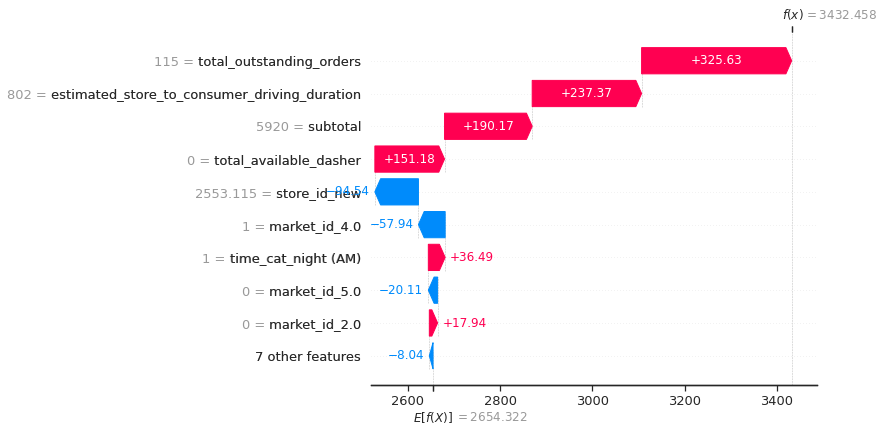

In [ ]:
# explain the model's predictions using SHAP
# SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. 
# It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

#The plot below shows features each contributing to push the model output from the base value (the average model output over the X_test we input) to the model output. 
#Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

In [ ]:
# visualize the first prediction's explanation with a force plot
shap.initjs()
shap.plots.force(shap_values[0])

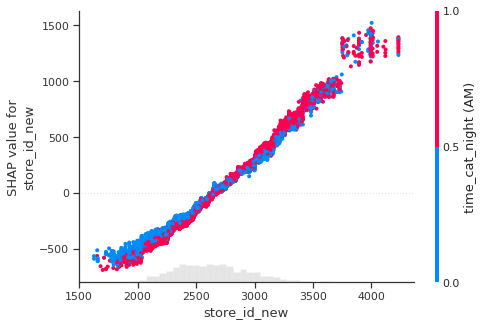

In [ ]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
# check interaction
shap.plots.scatter(shap_values[:,"store_id_new"], color=shap_values)

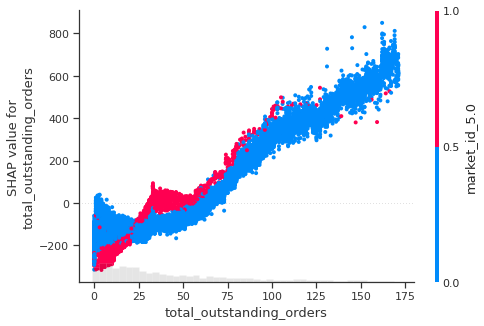

In [ ]:
shap.plots.scatter(shap_values[:,"total_outstanding_orders"], color=shap_values)

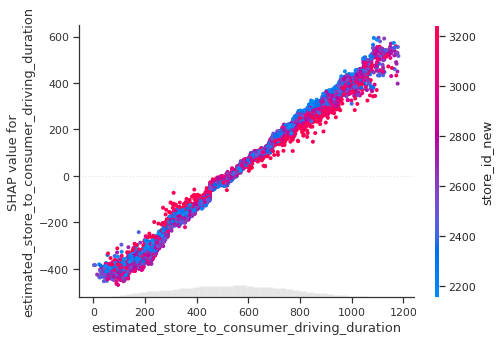

In [ ]:
shap.plots.scatter(shap_values[:,"estimated_store_to_consumer_driving_duration"], color=shap_values)

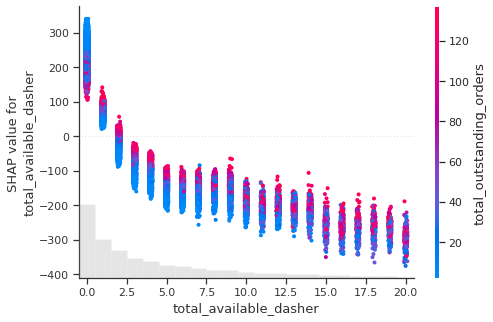

In [ ]:
shap.plots.scatter(shap_values[:,"total_available_dasher"], color=shap_values)

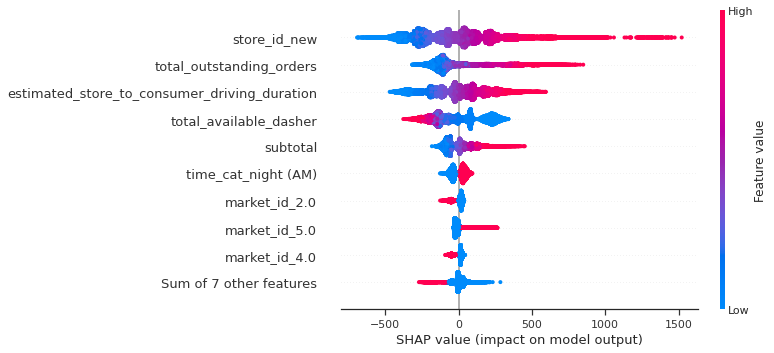

In [ ]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)


# To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. 
# The plot below sorts features by the sum of SHAP value magnitudes over all samples, 
# and uses SHAP values to show the distribution of the impacts each feature has on the model output. 
# The color represents the feature value (red high, blue low). 
# This reveals for example that:
# high total_outstanding_orders (Number of orders within 10 miles of this order that are currently being processed) increases the actual_total_delivery_duration_seconds.

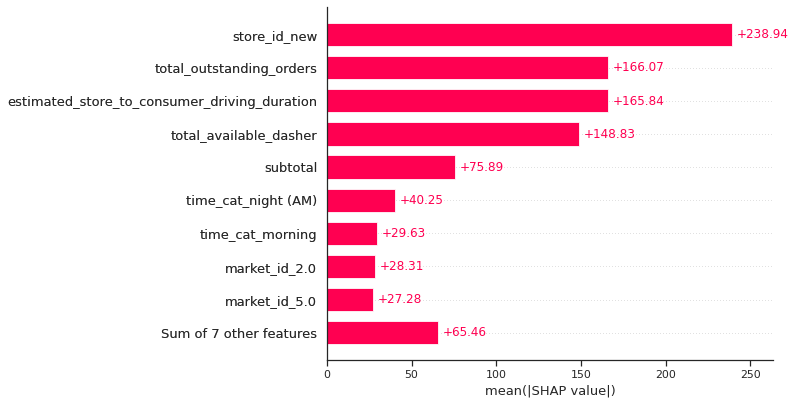

In [ ]:
# We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot
shap.plots.bar(shap_values)


In [ ]:
# underestimate percentage vs overestimate percentage
test_results = X_test.copy()
test_results['preds'] = preds
test_results['true'] = y_test
test_results.head()

store_id_new  subtotal  total_outstanding_orders  \
121850   2553.115248      5920                     115.0   
106557   2307.798357      1350                       2.0   
155448   3205.439605      2300                      34.0   
97039    2514.303109      4000                       4.0   
194956   2210.927174       949                       9.0   

        estimated_store_to_consumer_driving_duration  total_available_dasher  \
121850                                         802.0                     0.0   
106557                                         213.0                     1.0   
155448                                         906.0                     4.0   
97039                                          407.0                     1.0   
194956                                         534.0                     4.0   

        market_id_1.0  market_id_2.0  market_id_3.0  market_id_4.0  \
121850              0              0              0              1   
106557              0              0              0              1   
155448              0              1              0              0   
97039               0              1              0              0   
194956              0              1              0              0   

        market_id_5.0  market_id_6.0  time_cat_afternoon  time_cat_evening  \
121850              0              0                   0                 0   
106557              0              0                   0                 1   
155448              0              0                   0                 0   
97039               0              0                   0                 1   
194956              0              0                   0                 1   

        time_cat_morning  time_cat_night (AM)  time_cat_night (PM)  \
121850                 0                    1                    0   
106557                 0                    0                    0   
155448                 0                    1                    0   
97039                  0                    0                    0   
194956                 0                    0                    0   

              preds    true  
121850  3432.457822  4001.0  
106557  1886.682340  2075.0  
155448  3278.581308  3927.0  
97039   2350.599239  1906.0  
194956  1832.068868  1624.0

In [ ]:
# As notified: 
# Order lateness / underprediction of delivery time is of
# particular concern as past experiments suggest that underestimating delivery time is roughly twice as costly as
# overestimating it. Orders that are very early / late are also much worse than those that are only slightly early / late


test_results[['preds','true']].describe()
# preds are more centralized round mean than true values in actual total devlivery time. Model is underestimates (long tail right skew) high delivery time cases.



preds          true
count  28550.000000  28550.000000
mean    2656.949230   2661.120175
std      501.598628    845.715800
min     1105.136660    406.000000
25%     2294.694532   2035.000000
50%     2631.908706   2554.000000
75%     3003.925681   3187.000000
max     4703.286778   5102.000000

In [ ]:
# if we assume underestimating is prediction less than 90% of the true delivery time
# for example, the average true delivery time is 2554 seconds (43 mins), 90% of it is 38 mins, delta is about 4 to 5 mins 
test_results['underestimating'] = test_results.apply(lambda x: 1 if x['preds'] <= x['true']*0.9 else 0, axis=1)
print(f"{round(test_results['underestimating'].sum()/len(test_results['underestimating'])*100, 2)}% of the predictions underestimate the actual total devlivery time ")

29.4% of the predictions underestimate the actual total devlivery time 


In [ ]:
# if we assume overestimating is prediction more than 110% of the true delivery time
# for example, the average true delivery time is 2554 seconds (43 mins), 110% of it is 47 mins, delta is about 4 to 5 mins 
test_results['overestimating'] = test_results.apply(lambda x: 1 if x['preds'] >= x['true']*1.1 else 0, axis=1)
print(f"{round(test_results['overestimating'].sum()/len(test_results['overestimating'])*100, 2)}% of the predictions overestimate the actual total devlivery time ")

40.41% of the predictions overestimate the actual total devlivery time 


#### 3.2 Random Forest (grid search)

In [ ]:
# Number of trees in random forest
# n_estimators = [50, 100, 300, 500, 800]
n_estimators = [50, 100, 200]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,  4,  6, 7]
max_depth.append(None)
# Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth
              #  'min_samples_split': min_samples_split,
              #  'min_samples_leaf': min_samples_leaf
               }
print(random_grid)

{'n_estimators': [50, 100, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4, 6, 7, None]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# Random search of parameters, using 3 fold cross validation, 
rf_random = RandomizedSearchCV(estimator = rf(), param_distributions = random_grid, n_iter = 150, cv = 3, verbose=2, random_state=42, n_jobs = 3)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=150,
                   n_jobs=3,
                   param_distributions={'max_depth': [2, 4, 6, 7, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, verbose=2)

In [ ]:
rf_random.best_params_

{'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}

In [ ]:
rf_model = rf(n_jobs=10,n_estimators=200, max_features='sqrt', max_depth=None,random_state=10)
# Fit model
rf_model.fit(X_train, y_train)
# Get predictions
rf_preds = rf_model.predict(X_test)

print('Test MAE  : %.3f'%mean_absolute_error(y_test, rf_preds))
print('Train MAE : %.3f'%mean_absolute_error(y_train, rf_model.predict(X_train)))
print('Test MSE  : %.3f'%mean_squared_error(y_test, rf_preds))
print('Train MSE : %.3f'%mean_squared_error(y_train, rf_model.predict(X_train)))
print('Test RMSE  : %.3f'%sqrt(mean_squared_error(y_test, rf_preds)))
print('Train RMSE : %.3f'%sqrt(mean_squared_error(y_train, rf_model.predict(X_train))))

Test MAE  : 543.057
Train MAE : 202.046
Test MSE  : 477018.888
Train MSE : 66512.497
Test RMSE  : 690.666
Train RMSE : 257.900


In [ ]:
rfmodel = rf(n_jobs=10,n_estimators=200,max_features='sqrt',max_depth=None,random_state=10)

# Fit model
rfmodel.fit(X_train, y_train)
# Get predictions
rfpreds = rfmodel.predict(X_test)

In [ ]:
print('Test RMSE  : %.3f'%sqrt(mean_squared_error(y_test, rfpreds)))
print('Train RMSE : %.3f'%sqrt(mean_squared_error(y_train, rfmodel.predict(X_train))))

Test RMSE  : 690.666
Train RMSE : 257.900


In [ ]:
# Save the model as a pickle in a file
joblib.dump(rf_model, '/content/gdrive/MyDrive/Colab Notebooks/rf_model.pkl')
joblib.dump(rfmodel, '/content/gdrive/MyDrive/Colab Notebooks/rfmodel.pkl')

# Load the model from the file
rf_model_from_joblib = joblib.load('/content/gdrive/MyDrive/Colab Notebooks/rf_model.pkl')
rfmodel_from_joblib = joblib.load('/content/gdrive/MyDrive/Colab Notebooks/rfmodel.pkl')
# Use the loaded model to make predictions
# rf_preds = rf_model_from_joblib.predict(X_test)

array([3436.625, 1895.265, 3309.505, ..., 2221.11 , 2330.105, 3243.105])

In [ ]:
gc.collect()

88

#### 3.3 Catboost and Random forest ensemble model

In [ ]:
# ensemble model
from sklearn.ensemble import VotingRegressor

# regressor 1
r1 = CatBoostRegressor(
iterations=500,
depth=6,
learning_rate=0.05,
loss_function='RMSE',
eval_metric='RMSE',
random_seed=42,
# thread_count = 10,
logging_level='Silent'
# cat_features=CATEGORICAL_FEATS      
)

# regressor 2
r2 = rf(n_jobs=10,n_estimators=200, max_features='sqrt', max_depth=None,random_state=10)

# ensemble regressor
er = VotingRegressor([('CB', r1), ('rf', r2)])
er_preds = er.fit(X_train, y_train).predict(X_test)

print('Test MAE  : %.3f'%mean_absolute_error(y_test, er_preds))
print('Test MSE  : %.3f'%mean_squared_error(y_test, er_preds))
print('Test RMSE  : %.3f'%sqrt(mean_squared_error(y_test, er_preds)))

Test MAE  : 534.655
Test MSE  : 462415.360
Test RMSE  : 680.011


In [ ]:
# CV on train data with catboost
r1 = CatBoostRegressor(
iterations=500,
depth=6,
learning_rate=0.05,
loss_function='RMSE',
eval_metric='RMSE',
random_seed=42,
# thread_count = 10,
logging_level='Silent'
# cat_features=CATEGORICAL_FEATS      
)

r1_preds_train = cross_val_predict(r1, X_train, y_train, cv=3)

print('Train MAE : %.3f'%mean_absolute_error(y_train, r1_preds_train))
print('Train MSE : %.3f'%mean_squared_error(y_train, r1_preds_train))
print('Train RMSE : %.3f'%sqrt(mean_squared_error(y_train, r1_preds_train)))


Train MAE : 536.664
Train MSE : 465391.643
Train RMSE : 682.196


In [ ]:
# CV on test data with catboost
r1 = CatBoostRegressor(
iterations=500,
depth=6,
learning_rate=0.05,
loss_function='RMSE',
eval_metric='RMSE',
random_seed=42,
# thread_count = 10,
logging_level='Silent'
# cat_features=CATEGORICAL_FEATS      
)

r1_preds_test = cross_val_predict(r1, X_test, y_test, cv=3)

print('Test MAE : %.3f'%mean_absolute_error(y_test, r1_preds_test))
print('Test MSE : %.3f'%mean_squared_error(y_test, r1_preds_test))
print('Test RMSE : %.3f'%sqrt(mean_squared_error(y_test, r1_preds_test)))

Test MAE : 537.207
Test MSE : 467268.322
Test RMSE : 683.570


#### 3.4 quick test with xgboost

In [ ]:
# XGBmodel = XGBRegressor(n_jobs=3, n_estimators=500, max_depth=None, random_state=33)

XGBmodel = XGBRegressor(random_state=33)
# Fit model
XGBmodel.fit(X_train, y_train)
# Get predictions
XGBpreds = XGBmodel.predict(X_test)
print('Test RMSE  : %.3f'%sqrt(mean_squared_error(y_test, XGBpreds)))
print('Train RMSE : %.3f'%sqrt(mean_squared_error(y_train, XGBmodel.predict(X_train))))


[22:05:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Test RMSE  : 684.263
Train RMSE : 682.988


#### 3.5 quick test with MLP

In [ ]:
# quick test with MLP

# class sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(100,), 
#                                           activation='relu', *, solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', 
#                                           learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, 
#                                           verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, 
#                                           validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)

In [ ]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train[:10], y_train[:10])
regr_preds = regr.predict(X_test[:10])

In [ ]:
print('Test RMSE : %.3f'%sqrt(mean_squared_error(y_test[:10], regr_preds)))

Test RMSE : 477.425


In [ ]:
regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)
regr_preds = regr.predict(X_test)

In [ ]:
print('Test RMSE : %.3f'%sqrt(mean_squared_error(y_test, regr_preds)))

Test RMSE : 688.359


#### 3.6 Four regressors ensemble model

In [ ]:
# ensemble model
from sklearn.ensemble import VotingRegressor

# regressor 1
r1 = CatBoostRegressor()

# regressor 2
r2 = rf()

# regressor 3
r3 = XGBRegressor()

# regressor 3
r4 = MLPRegressor()


# ensemble regressor
er = VotingRegressor([('CB', r1), ('rf', r2),('xgb', r3), ('mlp', r4)])
er_preds = er.fit(X_train, y_train).predict(X_test)

print('Test MAE  : %.3f'%mean_absolute_error(y_test, er_preds))
print('Test MSE  : %.3f'%mean_squared_error(y_test, er_preds))
print('Test RMSE  : %.3f'%sqrt(mean_squared_error(y_test, er_preds)))

Learning rate set to 0.082708
0:	learn: 832.1952335	total: 28.7ms	remaining: 28.7s
1:	learn: 817.0479324	total: 48.1ms	remaining: 24s
2:	learn: 803.4881361	total: 62.3ms	remaining: 20.7s
3:	learn: 791.3820940	total: 75.7ms	remaining: 18.8s
4:	learn: 781.0189779	total: 87.8ms	remaining: 17.5s
5:	learn: 771.9254098	total: 100ms	remaining: 16.6s
6:	learn: 764.0357341	total: 113ms	remaining: 16s
7:	learn: 756.6547396	total: 132ms	remaining: 16.4s
8:	learn: 750.3124988	total: 145ms	remaining: 15.9s
9:	learn: 744.6399339	total: 157ms	remaining: 15.5s
10:	learn: 739.7917831	total: 170ms	remaining: 15.2s
11:	learn: 735.2019355	total: 185ms	remaining: 15.2s
12:	learn: 731.3509162	total: 198ms	remaining: 15s
13:	learn: 727.6458349	total: 211ms	remaining: 14.8s
14:	learn: 724.2287193	total: 224ms	remaining: 14.7s
15:	learn: 721.5212169	total: 242ms	remaining: 14.9s
16:	learn: 718.9375746	total: 254ms	remaining: 14.7s
17:	learn: 716.6477513	total: 266ms	remaining: 14.5s
18:	learn: 714.3517195	tota

In [ ]:
##### Test MAE  : 537.346
##### Test MSE  : 463562.558
##### Test RMSE  : 680.854

In [ ]:
# alternative thoughts

# we may categorise the target variable into "less than 5 mins", "5 to 10 mins", "10 to 15 mins", "15 to 20 mins", "20 to 25 mins", 
# with interval of 5 mins, to "longer than 45 mins"
# however, the requirement is predict in seconds

# after reviewing literatures, predict estimate time of different steps in the entire delivery process may help predict the total delivery time more accurately
# food processing time  =  actual delivery time - estimated store to destination time
# merge back to predict dataset ? 

# mean encoding for store id with weights MI encoding

#### 3.7 try some more feature engineering

In [ ]:
# read in data, parse date for sure
historical_data_try = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/historical_data.csv",  parse_dates=['created_at', 'actual_delivery_time'])
historical_data_try.dropna(inplace=True)
historical_data_try['actual_total_delivery_duration_seconds']  = historical_data_try['actual_delivery_time'] - historical_data_try['created_at'] 
historical_data_try['actual_total_delivery_duration_seconds'] = historical_data_try['actual_total_delivery_duration_seconds'].dt.total_seconds()
historical_data_try['estimated_food_processing_duration_seconds']  = historical_data_try['actual_total_delivery_duration_seconds'] - historical_data_try['estimated_store_to_consumer_driving_duration'] 
historical_data_try['total_available_dasher']  = historical_data_try['total_onshift_dashers'] - historical_data_try['total_busy_dashers'] 
historical_data_try.drop(historical_data_try[historical_data_try['total_available_dasher'] < 0].index, inplace=True)

In [ ]:
historical_data_try.describe(include = 'all')

market_id           created_at actual_delivery_time  \
count   139638.000000               139638               139638   
unique            NaN               130016               128503   
top               NaN  2015-02-11 19:50:43  2015-02-11 20:40:45   
freq              NaN                    6                    5   
first             NaN  2015-01-21 15:22:03  2015-01-21 15:58:11   
last              NaN  2015-02-18 06:00:44  2015-02-19 22:45:31   
mean         2.815695                  NaN                  NaN   
std          1.337605                  NaN                  NaN   
min          1.000000                  NaN                  NaN   
25%          2.000000                  NaN                  NaN   
50%          3.000000                  NaN                  NaN   
75%          4.000000                  NaN                  NaN   
max          6.000000                  NaN                  NaN   

             store_id       subtotal  total_onshift_dashers  \
count   139638.000000  139638.000000          139638.000000   
unique            NaN            NaN                    NaN   
top               NaN            NaN                    NaN   
freq              NaN            NaN                    NaN   
first             NaN            NaN                    NaN   
last              NaN            NaN                    NaN   
mean      3555.545733    2712.480800              45.985570   
std       2054.767976    1845.306012              36.086464   
min          1.000000       0.000000               0.000000   
25%       1703.000000    1414.000000              17.000000   
50%       3620.000000    2237.000000              37.000000   
75%       5336.000000    3445.000000              68.000000   
max       6987.000000   22500.000000             171.000000   

        total_busy_dashers  total_outstanding_orders  \
count        139638.000000             139638.000000   
unique                 NaN                       NaN   
top                    NaN                       NaN   
freq                   NaN                       NaN   
first                  NaN                       NaN   
last                   NaN                       NaN   
mean             39.744282                 58.004139   
std              31.687777                 54.334966   
min              -5.000000                 -6.000000   
25%              13.000000                 15.000000   
50%              32.000000                 39.000000   
75%              60.000000                 87.000000   
max             148.000000                285.000000   

        estimated_store_to_consumer_driving_duration  \
count                                  139638.000000   
unique                                           NaN   
top                                              NaN   
freq                                             NaN   
first                                            NaN   
last                                             NaN   
mean                                      545.713072   
std                                       219.004200   
min                                         0.000000   
25%                                       383.000000   
50%                                       543.000000   
75%                                       702.000000   
max                                      1711.000000   

        actual_total_delivery_duration_seconds  \
count                            139638.000000   
unique                                     NaN   
top                                        NaN   
freq                                       NaN   
first                                      NaN   
last                                       NaN   
mean                               2843.000995   
std                                1754.171313   
min                                 297.000000   
25%                                2097.000000   
50%                                2645.000000   
75%                 

# **I found estimated_food_processing_time has negative values, new data error found ! :)**

In [ ]:
historical_data_try.drop(historical_data_try[historical_data_try['estimated_food_processing_duration_seconds'] < 0].index, inplace=True)

In [ ]:
print("Previous data has 139638 rows")
print(f"Now data has {historical_data_try.shape[0]} rows")
print(f'{139638 - historical_data_try.shape[0]} rows removed !')


Previous data has 139638 rows
Now data has 139629 rows
9 rows removed !


In [ ]:
# drop outlier using IQR
def drop_outlier(df):
    outlier_cols = ['subtotal', 'total_available_dasher', 'total_outstanding_orders','estimated_food_processing_duration_seconds', 'estimated_store_to_consumer_driving_duration', 'actual_total_delivery_duration_seconds']
    for col in outlier_cols:
        Q1 = np.percentile(df[col], 25, interpolation = 'midpoint')
        Q3 = np.percentile(df[col], 75, interpolation = 'midpoint')
        IQR = Q3 - Q1
        print(f'For {col}, Q1 is {Q1}, Q3 is {Q3}, IQR is {IQR}.')
        
        print(f"{df} shape before removing outlier: {df.shape}.")
        
        # Upper bound
        upper = Q3+1.5*IQR
        # Lower bound
        lower = Q1-1.5*IQR
        print(f'For {col}, Upper bound is {upper}, Lower bound is {lower}')
        
        ''' Removing the Outliers '''
        df.drop(df[df[col] > upper].index, inplace=True)
        df.drop(df[df[col] < lower].index, inplace=True)
        
        print(f"{df} shape after removing outlier: {df.shape}.")
    return df

drop_outlier(historical_data_try)

For subtotal, Q1 is 1415.0, Q3 is 3445.0, IQR is 2030.0.
        market_id          created_at actual_delivery_time  store_id  \
0             1.0 2015-02-06 22:24:17  2015-02-06 23:27:16      1845   
2             3.0 2015-01-22 20:39:28  2015-01-22 21:09:09      5477   
3             3.0 2015-02-03 21:21:45  2015-02-03 22:13:00      5477   
4             3.0 2015-02-15 02:40:36  2015-02-15 03:20:26      5477   
5             3.0 2015-01-28 20:30:38  2015-01-28 21:08:58      5477   
...           ...                 ...                  ...       ...   
197420        2.0 2015-02-18 02:16:04  2015-02-18 03:12:36      2956   
197423        1.0 2015-02-17 00:19:41  2015-02-17 01:24:48      2956   
197424        1.0 2015-02-13 00:01:59  2015-02-13 00:58:22      2956   
197426        1.0 2015-02-01 18:18:15  2015-02-01 19:23:22      3630   
197427        1.0 2015-02-08 19:24:33  2015-02-08 20:01:41      3630   

        subtotal  total_onshift_dashers  total_busy_dashers  \
0           344

market_id          created_at actual_delivery_time  store_id  \
0             1.0 2015-02-06 22:24:17  2015-02-06 23:27:16      1845   
2             3.0 2015-01-22 20:39:28  2015-01-22 21:09:09      5477   
4             3.0 2015-02-15 02:40:36  2015-02-15 03:20:26      5477   
5             3.0 2015-01-28 20:30:38  2015-01-28 21:08:58      5477   
6             3.0 2015-01-31 02:16:36  2015-01-31 02:43:00      5477   
...           ...                 ...                  ...       ...   
197420        2.0 2015-02-18 02:16:04  2015-02-18 03:12:36      2956   
197423        1.0 2015-02-17 00:19:41  2015-02-17 01:24:48      2956   
197424        1.0 2015-02-13 00:01:59  2015-02-13 00:58:22      2956   
197426        1.0 2015-02-01 18:18:15  2015-02-01 19:23:22      3630   
197427        1.0 2015-02-08 19:24:33  2015-02-08 20:01:41      3630   

        subtotal  total_onshift_dashers  total_busy_dashers  \
0           3441                   33.0                14.0   
2           1900                    1.0                 0.0   
4           3900                    6.0                 6.0   
5           5000                    2.0                 2.0   
6           3900                   10.0                 9.0   
...          ...                    ...                 ...   
197420      2352                   49.0                49.0   
197423      1389                   17.0                17.0   
197424      3010                   12.0                11.0   
197426      1175                    7.0                 7.0   
197427      2605                   20.0                20.0   

        total_outstanding_orders  \
0                           21.0   
2                            0.0   
4                            9.0   
5                            2.0   
6                            9.0   
...                          ...   
197420                      65.0   
197423                      23.0   
197424                      14.0   
197426                      12.0   
197427                      23.0   

        estimated_store_to_consumer_driving_duration  \
0                                              861.0   
2                                              690.0   
4                                              650.0   
5                                              338.0   
6                                              638.0   
...                                              ...   
197420                                         560.0   
197423                                         331.0   
197424                                         915.0   
197426                                         384.0   
197427                                         134.0   

        actual_total_delivery_duration_seconds  \
0                                       3779.0   
2                                       1781.0   
4                                       2390.0   
5                                       2300.0   
6                                       1584.0   
...                                        ...   
197420                                  3392.0   
197423                                  3907.0   
197424                                  3383.0   
197426                                  3907.0   
197427                                  2228.0   

        estimated_food_processing_duration_seconds  total_available_dasher  
0                                           2918.0                    19.0  
2                                           1091.0                     1.0  
4                                           1740.0                     0.0  
5                                           1962.0                     0.0  
6                                            946.0                     1.0  
...                                            ...                     ...  
197420                                      2832.0                     0.0  
197423                                      3576.0             

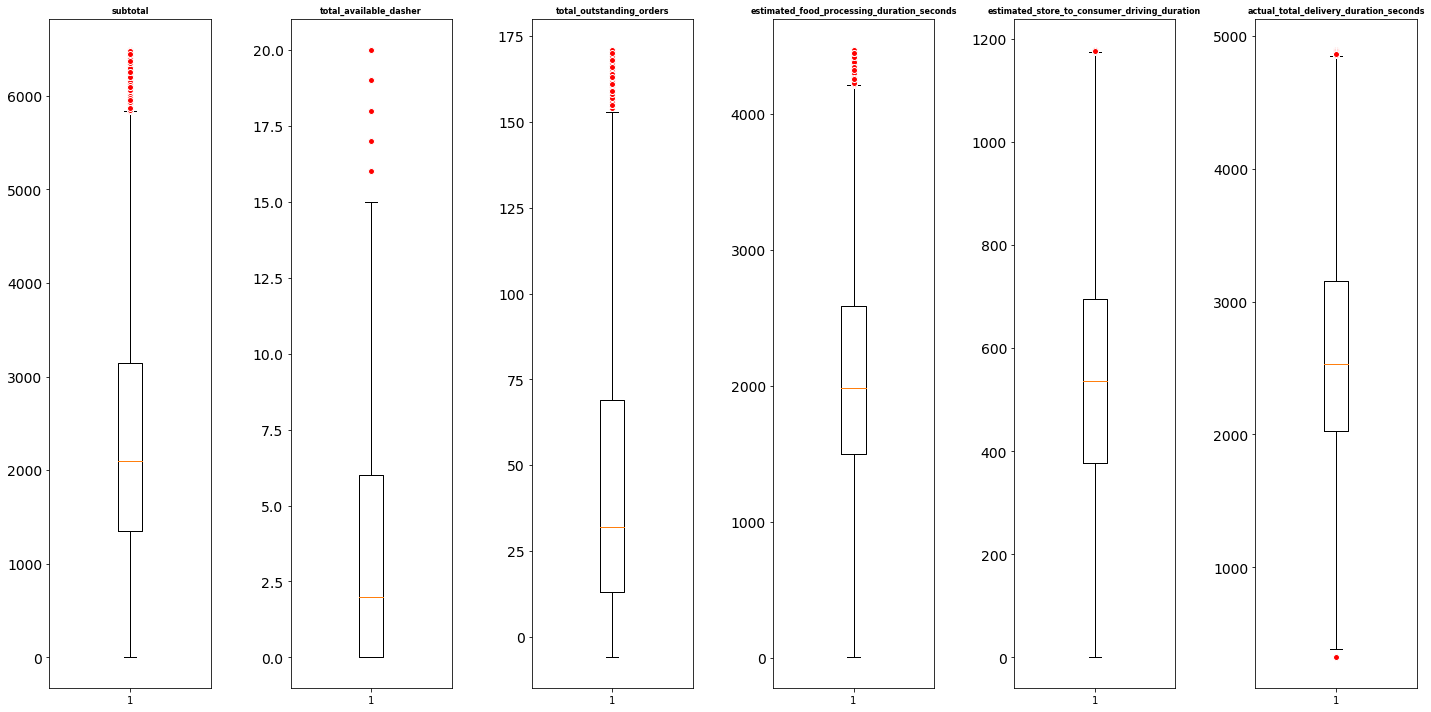

In [ ]:
# review data for outlier: we can see that there are many potential outliers, especially for "actual_total_delivery_duration_seconds"
check_outlier = historical_data_try[['subtotal','total_available_dasher',
       'total_outstanding_orders',
       'estimated_food_processing_duration_seconds',
       'estimated_store_to_consumer_driving_duration',
       'actual_total_delivery_duration_seconds']]

def box_plot(df):
    red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')
    fig, axs = plt.subplots(1, len(df.columns), figsize=(20,10))
    for i, ax in enumerate(axs.flat):
        ax.boxplot(df.iloc[:,i], flierprops=red_circle)
        ax.set_title(df.columns[i], fontsize=8, fontweight='bold')
        ax.tick_params(axis='y', labelsize=14)
    return plt.tight_layout()

box_plot(check_outlier)

In [ ]:
historical_data_try.columns

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'subtotal', 'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration',
       'actual_total_delivery_duration_seconds',
       'estimated_food_processing_duration_seconds', 'total_available_dasher'],
      dtype='object')

In [ ]:
historical_data_try_1 = historical_data_try[['market_id', 'created_at', 'store_id',
       'subtotal', 'total_available_dasher',
       'total_outstanding_orders',
       'estimated_food_processing_duration_seconds',
       'estimated_store_to_consumer_driving_duration',
       'actual_total_delivery_duration_seconds']]

In [ ]:
def create_at_time_categories(row):
    time_cats = {'morning':(time(5,0,0), time(11,59,59)), 'afternoon':(time(12,0,0), time(16,59,59)),
                 'evening':(time(17,0,0), time(20,59,59)), 'night (PM)':(time(21,0,0), time(23,59,59)), 
                 'night (AM)':(time(0,0,0), time(4,59,59))}
    for k, v in time_cats.items():
        if v[0] <= row['created_at'].time() <= v[1]:
            row['time_cat'] = k
    return row
historical_data_try_1 = historical_data_try_1.apply(create_at_time_categories, axis = "columns")

In [ ]:
# historical_data_try_1 = historical_data_try_1.apply(create_at_time_categories, axis = "columns")

In [ ]:
# take a look at the Average food processing time in each store for different time period and how many orders 
historical_data_try_1.groupby(["store_id", 'time_cat']).agg({'estimated_food_processing_duration_seconds': 'mean', 'actual_total_delivery_duration_seconds': 'count'})

estimated_food_processing_duration_seconds  \
store_id time_cat                                                 
1        evening                                    1649.000000   
         night (AM)                                 2371.000000   
         night (PM)                                 1443.000000   
2        evening                                    1480.000000   
         night (AM)                                 2148.000000   
...                                                         ...   
6986     evening                                    1854.000000   
         morning                                     800.000000   
         night (AM)                                 1756.642857   
         night (PM)                                 1431.000000   
6987     night (AM)                                 3283.000000   

                     actual_total_delivery_duration_seconds  
store_id time_cat                                            
1        evening                                          2  
         night (AM)                                       3  
         night (PM)                                       2  
2        evening                                          2  
         night (AM)                                       1  
...                                                     ...  
6986     evening                                          6  
         morning                                          1  
         night (AM)                                      14  
         night (PM)                                       8  
6987     night (AM)                                       1  

[14333 rows x 2 columns]

In [ ]:
# because in predict data, no actual delivery time was given, so no estimated_food_processing_duration_seconds can be calculated 
# therefore I calculate the average food processing time for each store in different time period as a new feature: "avg_cook_time"
avg_cook_time = historical_data_try_1.groupby(["store_id", 'time_cat']).agg(
    {'estimated_food_processing_duration_seconds': 'mean', 'actual_total_delivery_duration_seconds': 'count'}).reset_index()
avg_cook_time = avg_cook_time[['store_id',	'time_cat',	'estimated_food_processing_duration_seconds']].rename(columns = {'estimated_food_processing_duration_seconds':'avg_cook_time'})

In [ ]:
historical_data_try_2 = historical_data_try_1.merge(avg_cook_time, how = 'left', on =['store_id','time_cat'] )

In [ ]:
historical_data_try_2.describe(include = 'all')
# looks like cooktime is a big reason that total delivery time is long

market_id           created_at       store_id       subtotal  \
count   113086.000000               113086  113086.000000  113086.000000   
unique            NaN               107634            NaN            NaN   
top               NaN  2015-02-11 19:50:43            NaN            NaN   
freq              NaN                    6            NaN            NaN   
first             NaN  2015-01-21 15:22:03            NaN            NaN   
last              NaN  2015-02-18 06:00:44            NaN            NaN   
mean         2.818041                  NaN    3568.778567    2385.382992   
std          1.363723                  NaN    2059.932429    1316.194360   
min          1.000000                  NaN       1.000000       0.000000   
25%          2.000000                  NaN    1712.000000    1350.000000   
50%          3.000000                  NaN    3624.000000    2095.000000   
75%          4.000000                  NaN    5362.000000    3145.000000   
max          6.000000                  NaN    6987.000000    6490.000000   

        total_available_dasher  total_outstanding_orders  \
count            113086.000000             113086.000000   
unique                     NaN                       NaN   
top                        NaN                       NaN   
freq                       NaN                       NaN   
first                      NaN                       NaN   
last                       NaN                       NaN   
mean                  4.149037                 46.232301   
std                   4.844907                 41.762097   
min                   0.000000                 -6.000000   
25%                   0.000000                 13.000000   
50%                   2.000000                 32.000000   
75%                   6.000000                 69.000000   
max                  20.000000                171.000000   

        estimated_food_processing_duration_seconds  \
count                                113086.000000   
unique                                         NaN   
top                                            NaN   
freq                                           NaN   
first                                          NaN   
last                                           NaN   
mean                                   2093.643351   
std                                     789.474982   
min                                       3.000000   
25%                                    1502.000000   
50%                                    1983.000000   
75%                                    2587.000000   
max                                    4473.000000   

        estimated_store_to_consumer_driving_duration  \
count                                  113086.000000   
unique                                           NaN   
top                                              NaN   
freq                                             NaN   
first                                            NaN   
last                                             NaN   
mean                                      539.218480   
std                                       216.644765   
min                                         0.000000   
25%                                       377.000000   
50%                                       537.000000   
75%                                       696.000000   
max                                      1179.000000   

        actual_total_delivery_duration_seconds    time_cat  avg_cook_time  
count                            113086.000000      113086  113086.000000  
unique                                     NaN           5            NaN  
top                                        NaN  night (AM)            NaN  
freq                                       NaN       63018            NaN  
first                                      NaN         NaN            NaN  
last                                       NaN         NaN            NaN  
mean                            

In [ ]:
historical_data_try_2 = historical_data_try_2[['market_id', 'store_id', 'subtotal',
       'total_available_dasher', 'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration',
       'time_cat', 'avg_cook_time',
       'actual_total_delivery_duration_seconds']]

In [ ]:
historical_data_try_2 = pd.get_dummies(historical_data_try_2, columns=['market_id', 'time_cat'])
historical_data_try_2.columns

Index(['store_id', 'subtotal', 'total_available_dasher',
       'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration', 'avg_cook_time',
       'actual_total_delivery_duration_seconds', 'market_id_1.0',
       'market_id_2.0', 'market_id_3.0', 'market_id_4.0', 'market_id_5.0',
       'market_id_6.0', 'time_cat_afternoon', 'time_cat_evening',
       'time_cat_morning', 'time_cat_night (AM)', 'time_cat_night (PM)'],
      dtype='object')

In [ ]:
historical_data_try_2['store_id_new'] ='store' + historical_data_try_2['store_id'].astype(str)
historical_data_try_2.columns

Index(['store_id', 'subtotal', 'total_available_dasher',
       'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration', 'avg_cook_time',
       'actual_total_delivery_duration_seconds', 'market_id_1.0',
       'market_id_2.0', 'market_id_3.0', 'market_id_4.0', 'market_id_5.0',
       'market_id_6.0', 'time_cat_afternoon', 'time_cat_evening',
       'time_cat_morning', 'time_cat_night (AM)', 'time_cat_night (PM)',
       'store_id_new'],
      dtype='object')

In [ ]:
historical_data_try_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113086 entries, 0 to 113085
Data columns (total 19 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   store_id                                      113086 non-null  int64  
 1   subtotal                                      113086 non-null  int64  
 2   total_available_dasher                        113086 non-null  float64
 3   total_outstanding_orders                      113086 non-null  float64
 4   estimated_store_to_consumer_driving_duration  113086 non-null  float64
 5   avg_cook_time                                 113086 non-null  float64
 6   actual_total_delivery_duration_seconds        113086 non-null  float64
 7   market_id_1.0                                 113086 non-null  uint8  
 8   market_id_2.0                                 113086 non-null  uint8  
 9   market_id_3.0                                 11

In [ ]:
historical_data_try_2.head()

store_id  subtotal  total_available_dasher  total_outstanding_orders  \
0      1845      3441                    19.0                      21.0   
1      5477      1900                     1.0                       0.0   
2      5477      3900                     0.0                       9.0   
3      5477      5000                     0.0                       2.0   
4      5477      3900                     1.0                       9.0   

   estimated_store_to_consumer_driving_duration  avg_cook_time  \
0                                         861.0    2918.000000   
1                                         690.0    1795.333333   
2                                         650.0    1695.000000   
3                                         338.0    1795.333333   
4                                         638.0    1695.000000   

   actual_total_delivery_duration_seconds  market_id_1.0  market_id_2.0  \
0                                  3779.0              1              0   
1                                  1781.0              0              0   
2                                  2390.0              0              0   
3                                  2300.0              0              0   
4                                  1584.0              0              0   

   market_id_3.0  market_id_4.0  market_id_5.0  market_id_6.0  \
0              0              0              0              0   
1              1              0              0              0   
2              1              0              0              0   
3              1              0              0              0   
4              1              0              0              0   

   time_cat_afternoon  time_cat_evening  time_cat_morning  \
0                   0                 0                 0   
1                   0                 1                 0   
2                   0                 0                 0   
3                   0                 1                 0   
4                   0                 0                 0   

   time_cat_night (AM)  time_cat_night (PM) store_id_new  
0                    0                    1    store1845  
1                    0                    0    store5477  
2                    1                    0    store5477  
3                    0                    0    store5477  
4                    1                    0    store5477

In [ ]:
historical_data_try_3 = historical_data_try_2[['store_id_new', 
       'subtotal', 
       'total_outstanding_orders', 'total_available_dasher', 
       'avg_cook_time',
       'estimated_store_to_consumer_driving_duration',
        'market_id_1.0','market_id_2.0', 'market_id_3.0', 'market_id_4.0', 'market_id_5.0','market_id_6.0', 
        'time_cat_afternoon', 'time_cat_evening','time_cat_morning', 'time_cat_night (AM)', 'time_cat_night (PM)',
        'actual_total_delivery_duration_seconds']]
target_new = historical_data_try_3[['actual_total_delivery_duration_seconds']]
train_new = historical_data_try_3.drop('actual_total_delivery_duration_seconds', axis = 1)
  
# Define catboost encoder
cbe_encoder_new = category_encoders.cat_boost.CatBoostEncoder()
  
# Fit encoder and transform the features
cbe_encoder_new.fit(train_new, target_new)
train_cbe_new = cbe_encoder_new.transform(train_new)

In [ ]:
# train_test_split
X = train_cbe_new[['store_id_new', 'subtotal', 
                   'total_outstanding_orders',
        'avg_cook_time',           
       'estimated_store_to_consumer_driving_duration',
       'total_available_dasher', 
       'market_id_1.0', 'market_id_2.0', 'market_id_3.0', 'market_id_4.0',
       'market_id_5.0', 'market_id_6.0', 'time_cat_afternoon',
       'time_cat_evening', 'time_cat_morning', 'time_cat_night (AM)',
       'time_cat_night (PM)']]


y = historical_data_try_3['actual_total_delivery_duration_seconds']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# evaluate model
model = CatBoostRegressor(
iterations=500,
depth=6,
learning_rate=0.05,
loss_function='RMSE',
eval_metric='RMSE',
random_seed=42,
# thread_count = 10,
logging_level='Silent'
# cat_features=CATEGORICAL_FEATS      
)
# Fit model
model.fit(X_train, y_train)
# Get predictions
preds = model.predict(X_test)
print(model.get_best_score())
print('Test MAE  : %.3f'%mean_absolute_error(y_test, preds))
print('Train MAE : %.3f'%mean_absolute_error(y_train, model.predict(X_train)))
print('Test MSE  : %.3f'%mean_squared_error(y_test, preds))
print('Train MSE : %.3f'%mean_squared_error(y_train, model.predict(X_train)))
print('Test RMSE  : %.3f'%sqrt(mean_squared_error(y_test, preds)))
print('Train RMSE : %.3f'%sqrt(mean_squared_error(y_train, model.predict(X_train))))

{'learn': {'RMSE': 611.5499052095714}}
Test MAE  : 484.701
Train MAE : 478.572
Test MSE  : 385497.813
Train MSE : 373993.287
Test RMSE  : 620.885
Train RMSE : 611.550



# Results after feature engineering on food process time 
{'learn': {'RMSE': 611.5499052095714}}
Test MAE  : 484.701
Train MAE : 478.572
Test MSE  : 385497.813
Train MSE : 373993.287
Test RMSE  : 620.885
Train RMSE : 611.550


# Results before feature engineering on food process time 
{'learn': {'RMSE': 672.0467387567832}}
Test MAE  : 532.795
Train MAE : 528.531
Test MSE  : 459716.139
Train MSE : 451646.819
Test RMSE  : 678.024
Train RMSE : 672.047

# After feature engineering on food process time, results is more accurate.

In [ ]:
model.save_model("/content/gdrive/MyDrive/Colab Notebooks/CBmodel_final")
# CBmodel_final = CatBoostRegressor()
# CBmodel_final.load_model("/content/gdrive/MyDrive/Colab Notebooks/CBmodel_final")

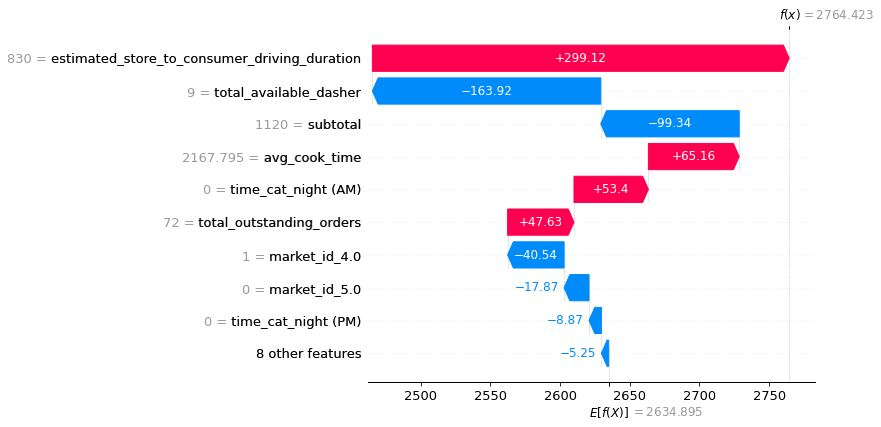

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [ ]:
shap.initjs()
shap.plots.force(shap_values[0])

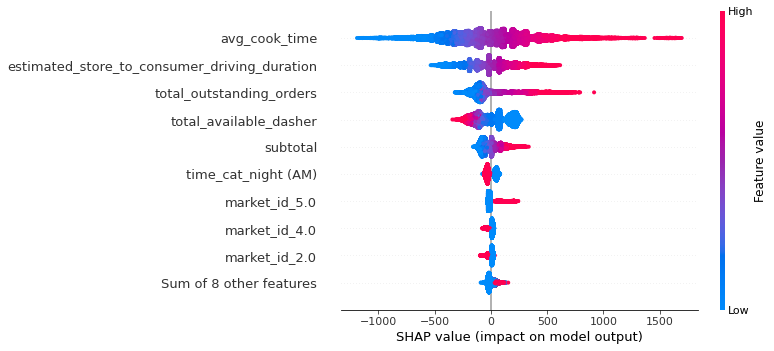

In [ ]:
shap.plots.beeswarm(shap_values)
# store_avg_cook_time is the key predictor

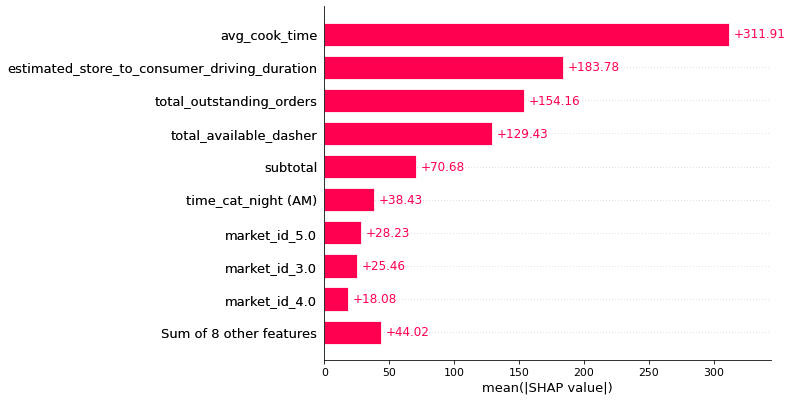

In [ ]:
shap.plots.bar(shap_values)

# In summary, store average food processing time in different time period is the key predictor, so was the estimated store to cunsumer driving duration

In [ ]:
# more model exploration

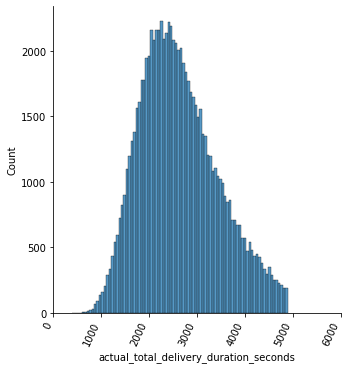

In [ ]:
# check target distribution
sns.displot(y_train).set_xticklabels(rotation=65, horizontalalignment='right')

In [ ]:
# check with gammaRegressor for exploration
from sklearn import linear_model
GammaLR = linear_model.GammaRegressor()
GammaLR.fit(X_train, y_train)
print(GammaLR.score(X_train, y_train))
print(GammaLR.coef_)
print(GammaLR.intercept_)
GammaLR_preds = GammaLR.predict(X_test)

print('Test MAE  : %.3f'%mean_absolute_error(y_test, GammaLR_preds))
print('Train MAE : %.3f'%mean_absolute_error(y_train, GammaLR.predict(X_train)))
print('Test MSE  : %.3f'%mean_squared_error(y_test, GammaLR_preds))
print('Train MSE : %.3f'%mean_squared_error(y_train, GammaLR.predict(X_train)))
print('Test RMSE  : %.3f'%sqrt(mean_squared_error(y_test, GammaLR_preds)))
print('Train RMSE : %.3f'%sqrt(mean_squared_error(y_train, GammaLR.predict(X_train))))


0.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
7.87659996546201
Test MAE  : 667.447
Train MAE : 662.347
Test MSE  : 678056.565
Train MSE : 670866.553
Test RMSE  : 823.442
Train RMSE : 819.064


In [ ]:
# re-test LR, results is better as RMSE goes from  693.8906249194683 to 632.5715700167225
mlr = LinearRegression()  
mlr.fit(X_train, y_train)
#Intercept and Coefficient
print("Intercept: ", mlr.intercept_)
print(f"Coefficients: {list(zip(X, mlr.coef_))}")
#Prediction of test set
y_pred_mlr= mlr.predict(X_test)
#Predicted values
# print("Prediction for test set: {}".format(y_pred_mlr))
#Actual value and the predicted value
mlr_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred_mlr})
mlr_diff.head()
#Model Evaluation
from sklearn import metrics
meanAbErr = metrics.mean_absolute_error(y_test, y_pred_mlr)
meanSqErr = metrics.mean_squared_error(y_test, y_pred_mlr)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_mlr))
print('R squared: {:.2f}'.format(mlr.score(X,y)*100))
print('Mean Absolute Error:', meanAbErr)
print('Mean Square Error:', meanSqErr)
print('Root Mean Square Error:', rootMeanSqErr)

Intercept:  -105.21698896601083
Coefficients: [('store_id_new', 0.006877064905653127), ('subtotal', 0.05916368725915344), ('total_outstanding_orders', 4.785125644507887), ('avg_cook_time', 0.9599114651179621), ('estimated_store_to_consumer_driving_duration', 1.018769451807377), ('total_available_dasher', -24.600632821987563), ('market_id_1.0', 21.205245671143615), ('market_id_2.0', -98.28155101617905), ('market_id_3.0', 77.91415867408965), ('market_id_4.0', -107.1359311946134), ('market_id_5.0', 110.16913212307652), ('market_id_6.0', -3.871054257517071), ('time_cat_afternoon', 100.26041167274188), ('time_cat_evening', -33.7843174084251), ('time_cat_morning', 30.085949789482534), ('time_cat_night (AM)', -138.36399657829833), ('time_cat_night (PM)', 41.80195252449889)]
R squared: 40.87
Mean Absolute Error: 493.6824033468075
Mean Square Error: 400146.7911934212
Root Mean Square Error: 632.5715700167225


In [ ]:
OLSmodel = sm.OLS(y_train,  X_train).fit() 
print(OLSmodel.summary())

                                      OLS Regression Results                                      
Dep. Variable:     actual_total_delivery_duration_seconds   R-squared:                       0.408
Model:                                                OLS   Adj. R-squared:                  0.408
Method:                                     Least Squares   F-statistic:                     3901.
Date:                                    Thu, 14 Apr 2022   Prob (F-statistic):               0.00
Time:                                            04:43:33   Log-Likelihood:            -6.6704e+05
No. Observations:                                   84814   AIC:                         1.334e+06
Df Residuals:                                       84798   BIC:                         1.334e+06
Df Model:                                              15                                         
Covariance Type:                                nonrobust                                         
          

In [ ]:
# ensemble model
from sklearn.ensemble import VotingRegressor

# regressor 1
r1 = CatBoostRegressor()

# regressor 2
r2 = rf()

# regressor 3
r3 = XGBRegressor()

# regressor 4
r4 = MLPRegressor()

# regressor 5
r5 = LinearRegression()


# ensemble regressor
er = VotingRegressor([('CB', r1), ('rf', r2),('xgb', r3), ('mlp', r4), ('lr', r5)])
er_preds = er.fit(X_train, y_train).predict(X_test)

print('Test MAE  : %.3f'%mean_absolute_error(y_test, er_preds))
print('Test MSE  : %.3f'%mean_squared_error(y_test, er_preds))
print('Test RMSE  : %.3f'%sqrt(mean_squared_error(y_test, er_preds)))

Learning rate set to 0.08258
0:	learn: 797.5993903	total: 34.6ms	remaining: 34.5s
1:	learn: 778.5930658	total: 50.5ms	remaining: 25.2s
2:	learn: 762.1214584	total: 65ms	remaining: 21.6s
3:	learn: 747.9088675	total: 108ms	remaining: 26.9s
4:	learn: 734.9505927	total: 143ms	remaining: 28.5s
5:	learn: 723.7060098	total: 187ms	remaining: 30.9s
6:	learn: 713.9036238	total: 214ms	remaining: 30.4s
7:	learn: 705.3975272	total: 249ms	remaining: 30.9s
8:	learn: 697.4622543	total: 279ms	remaining: 30.7s
9:	learn: 690.4591394	total: 315ms	remaining: 31.2s
10:	learn: 684.3025285	total: 357ms	remaining: 32.1s
11:	learn: 678.8187504	total: 382ms	remaining: 31.5s
12:	learn: 674.1173249	total: 399ms	remaining: 30.3s
13:	learn: 669.6609713	total: 421ms	remaining: 29.6s
14:	learn: 665.6384231	total: 438ms	remaining: 28.8s
15:	learn: 662.1359109	total: 475ms	remaining: 29.2s
16:	learn: 659.0869035	total: 505ms	remaining: 29.2s
17:	learn: 656.2596108	total: 526ms	remaining: 28.7s
18:	learn: 653.8024863	tot

ensemble model
Test MAE  : 487.875
Test MSE  : 390332.199
Test RMSE  : 624.766

In [ ]:
# catboost win with RMSE as 611.550. decsided to use catboost with best parameters as explored
catboost_w = CatBoostRegressor(
iterations=500,
depth=6,
learning_rate=0.05,
loss_function='RMSE',
eval_metric='RMSE',
random_seed=42,
# thread_count = 10,
logging_level='Silent'
# cat_features=CATEGORICAL_FEATS      
)

In [ ]:
CB_train = train_cbe_new[['store_id_new', 'subtotal', 
                   'total_outstanding_orders',
        'avg_cook_time',           
       'estimated_store_to_consumer_driving_duration',
       'total_available_dasher', 
       'market_id_1.0', 'market_id_2.0', 'market_id_3.0', 'market_id_4.0',
       'market_id_5.0', 'market_id_6.0', 'time_cat_afternoon',
       'time_cat_evening', 'time_cat_morning', 'time_cat_night (AM)',
       'time_cat_night (PM)']]


CB_target = historical_data_try_3['actual_total_delivery_duration_seconds']

In [ ]:
# Fit model
catboost_w.fit(CB_train, CB_target)
# Get predictions
CB_preds = catboost_w.predict(CB_train)
print(catboost_w.get_best_score())

print('CB Train MAE : %.3f'%mean_absolute_error(CB_target, catboost_w.predict(CB_train)))

print('CB Train MSE : %.3f'%mean_squared_error(CB_target, catboost_w.predict(CB_train)))

print('CB Train RMSE : %.3f'%sqrt(mean_squared_error(CB_target, catboost_w.predict(CB_train))))

# {'learn': {'RMSE': 613.3010582923628}}
# CB Train MAE : 479.599
# CB Train MSE : 376138.188
# CB Train RMSE : 613.301

{'learn': {'RMSE': 613.3010582923628}}
CB Train MAE : 479.599
CB Train MSE : 376138.188
CB Train RMSE : 613.301


In [ ]:
catboost_w.save_model("/content/gdrive/MyDrive/Colab Notebooks/Catboost_w")
# CBmodel_final = CatBoostRegressor()
# CBmodel_final.load_model("/content/gdrive/MyDrive/Colab Notebooks/CBmodel_final")

#### 3.8 Final model using catboost

Notes:
1. In final training I will not use target econding (catboost encoder) on store ID because in predict data, there is no target column.

2. I will merge store avaerage food processing time (different time period of the day) from training data to predict data as a new feature

3. Some thoughts:training data may could be seprated to two sets after remove error data, one is data fall into long tail, the other sets is the rest; maybe train different models on these two sets. maybe treat predict data as two sets as well and then use trained two models to predict on two sets and combine results. 





In [ ]:
CB_train = train_cbe_new[['subtotal', 
                   'total_outstanding_orders',
        'avg_cook_time',           
       'estimated_store_to_consumer_driving_duration',
       'total_available_dasher', 
       'market_id_1.0', 'market_id_2.0', 'market_id_3.0', 'market_id_4.0',
       'market_id_5.0', 'market_id_6.0', 'time_cat_afternoon',
       'time_cat_evening', 'time_cat_morning', 'time_cat_night (AM)',
       'time_cat_night (PM)']]


CB_target = historical_data_try_3['actual_total_delivery_duration_seconds']

In [ ]:
# Fit model
catboost_w.fit(CB_train, CB_target)
# Get predictions
CB_preds = catboost_w.predict(CB_train)
print(catboost_w.get_best_score())

print('CB Train MAE : %.3f'%mean_absolute_error(CB_target, catboost_w.predict(CB_train)))

print('CB Train MSE : %.3f'%mean_squared_error(CB_target, catboost_w.predict(CB_train)))

print('CB Train RMSE : %.3f'%sqrt(mean_squared_error(CB_target, catboost_w.predict(CB_train))))

{'learn': {'RMSE': 613.809465943368}}
CB Train MAE : 479.981
CB Train MSE : 376762.060
CB Train RMSE : 613.809


{'learn': {'RMSE': 613.809465943368}}
CB Train MAE : 479.981
CB Train MSE : 376762.060
CB Train RMSE : 613.809

After remove store_ID_new target encoded variable, the accuracy is almost the same. so remove it is the correct and necessary move.

In [ ]:
catboost_w.save_model("/content/gdrive/MyDrive/Colab Notebooks/Catboost_w_final")
# CBmodel_final = CatBoostRegressor()
# CBmodel_final.load_model("/content/gdrive/MyDrive/Colab Notebooks/CBmodel_final")

### 4. Make predictions

In [ ]:
predict_data = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/predict_data.csv", parse_dates=['created_at'])

predict_data.shape

(54778, 9)

In [ ]:
# predict_data.dropna(inplace=True)
predict_data['total_available_dasher']  = predict_data['total_onshift_dashers'] - predict_data['total_busy_dashers'] 
# predict_data.drop(predict_data[predict_data['total_available_dasher'] < 0].index, inplace=True)

In [ ]:
# drop outlier using IQR
# def drop_outlier(df):
#     outlier_cols = ['subtotal', 'total_available_dasher', 'total_outstanding_orders','estimated_food_processing_duration_seconds', 'estimated_store_to_consumer_driving_duration', 'actual_total_delivery_duration_seconds']
#     for col in outlier_cols:
#         Q1 = np.percentile(df[col], 25, interpolation = 'midpoint')
#         Q3 = np.percentile(df[col], 75, interpolation = 'midpoint')
#         IQR = Q3 - Q1
#         print(f'For {col}, Q1 is {Q1}, Q3 is {Q3}, IQR is {IQR}.')
        
#         print(f"{df} shape before removing outlier: {df.shape}.")
        
#         # Upper bound
#         upper = Q3+1.5*IQR
#         # Lower bound
#         lower = Q1-1.5*IQR
#         print(f'For {col}, Upper bound is {upper}, Lower bound is {lower}')
        
#         ''' Removing the Outliers '''
#         df.drop(df[df[col] > upper].index, inplace=True)
#         df.drop(df[df[col] < lower].index, inplace=True)
        
#         print(f"{df} shape after removing outlier: {df.shape}.")
#     return df

# drop_outlier(predict_data)

# # review data for outlier: we can see that there are many potential outliers, especially for "actual_total_delivery_duration_seconds"
# check_outlier = predict_data[['subtotal','total_available_dasher',
#        'total_outstanding_orders',
#        'estimated_food_processing_duration_seconds',
#        'estimated_store_to_consumer_driving_duration',
#        'actual_total_delivery_duration_seconds']]

# def box_plot(df):
#     red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')
#     fig, axs = plt.subplots(1, len(df.columns), figsize=(20,10))
#     for i, ax in enumerate(axs.flat):
#         ax.boxplot(df.iloc[:,i], flierprops=red_circle)
#         ax.set_title(df.columns[i], fontsize=8, fontweight='bold')
#         ax.tick_params(axis='y', labelsize=14)
#     return plt.tight_layout()

# box_plot(check_outlier)

In [ ]:
predict_data.columns

Index(['market_id', 'created_at', 'store_id', 'subtotal',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration', 'delivery_id',
       'total_available_dasher'],
      dtype='object')

In [ ]:
predict_data = predict_data[['market_id', 'created_at', 'store_id',
       'subtotal', 'total_available_dasher',
       'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration', 'delivery_id']]

In [ ]:
len(set(predict_data.store_id.unique()))

5676

In [ ]:
print(predict_data.store_id.nunique())
print(avg_cook_time.store_id.nunique())
print(historical_data.store_id.nunique())
print(f"predict_data and historical_data has {len(set(historical_data.store_id.unique())-set(predict_data.store_id.unique()))} different store_ids")

5676
5622
5703
predict_data and historical_data has 1042 different store_ids


In [ ]:
def create_at_time_categories(row):
    time_cats = {'morning':(time(5,0,0), time(11,59,59)), 'afternoon':(time(12,0,0), time(16,59,59)),
                 'evening':(time(17,0,0), time(20,59,59)), 'night (PM)':(time(21,0,0), time(23,59,59)), 
                 'night (AM)':(time(0,0,0), time(4,59,59))}
    for k, v in time_cats.items():
        if v[0] <= row['created_at'].time() <= v[1]:
            row['time_cat'] = k
    return row
predict_data = predict_data.apply(create_at_time_categories, axis = "columns")

In [ ]:
# avg_cook_time = historical_data_try_1.groupby(["store_id", 'time_cat']).agg(
#     {'estimated_food_processing_duration_seconds': 'mean', 'actual_total_delivery_duration_seconds': 'count'}).reset_index()
# avg_cook_time = avg_cook_time[['store_id',	'time_cat',	'estimated_food_processing_duration_seconds']].rename(columns = {'estimated_food_processing_duration_seconds':'avg_cook_time'})

In [ ]:
predict_data_1 = predict_data.merge(avg_cook_time, how = 'left', on =['store_id','time_cat'] )

In [ ]:
predict_data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54778 entries, 0 to 54777
Data columns (total 10 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   market_id                                     54528 non-null  float64       
 1   created_at                                    54778 non-null  datetime64[ns]
 2   store_id                                      54778 non-null  int64         
 3   subtotal                                      54778 non-null  int64         
 4   total_available_dasher                        50145 non-null  float64       
 5   total_outstanding_orders                      50145 non-null  float64       
 6   estimated_store_to_consumer_driving_duration  54767 non-null  float64       
 7   delivery_id                                   54778 non-null  int64         
 8   time_cat                                      54778 non-null  obje

In [ ]:
predict_data_1 = predict_data_1[['market_id', 'subtotal',
       'total_available_dasher', 'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration',
       'time_cat', 'avg_cook_time']]

In [ ]:
predict_data_1 = pd.get_dummies(predict_data_1, columns=['market_id', 'time_cat'])
predict_data_1.columns

Index(['subtotal', 'total_available_dasher', 'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration', 'avg_cook_time',
       'market_id_1.0', 'market_id_2.0', 'market_id_3.0', 'market_id_4.0',
       'market_id_5.0', 'market_id_6.0', 'time_cat_afternoon',
       'time_cat_evening', 'time_cat_morning', 'time_cat_night (AM)',
       'time_cat_night (PM)'],
      dtype='object')

In [ ]:
# train_test_split
predict_data_1 = predict_data_1[['subtotal', 
                   'total_outstanding_orders',
        'avg_cook_time',           
       'estimated_store_to_consumer_driving_duration',
       'total_available_dasher', 
       'market_id_1.0', 'market_id_2.0', 'market_id_3.0', 'market_id_4.0',
       'market_id_5.0', 'market_id_6.0', 'time_cat_afternoon',
       'time_cat_evening', 'time_cat_morning', 'time_cat_night (AM)',
       'time_cat_night (PM)']]

In [ ]:
# catboost_w.save_model("/content/gdrive/MyDrive/Colab Notebooks/Catboost_w_final")
CB_win_final = CatBoostRegressor()
CB_win_final.load_model("/content/gdrive/MyDrive/Colab Notebooks/Catboost_w_final")

In [ ]:
predict_data_1["predicted_duration"] = CB_win_final.predict(predict_data_1)

In [ ]:
predict_data_1.head()

subtotal  total_outstanding_orders  avg_cook_time  \
0      7500                       4.0         1695.0   
1      7100                       1.0         1695.0   
2      4500                       6.0         1695.0   
3      1700                       3.0         1695.0   
4      3150                       4.0            NaN   

   estimated_store_to_consumer_driving_duration  total_available_dasher  \
0                                         670.0                     0.0   
1                                         446.0                     3.0   
2                                         504.0                     2.0   
3                                         687.0                     0.0   
4                                         528.0                     0.0   

   market_id_1.0  market_id_2.0  market_id_3.0  market_id_4.0  market_id_5.0  \
0              0              0              1              0              0   
1              0              0              1              0              0   
2              0              0              0              1              0   
3              0              0              1              0              0   
4              1              0              0              0              0   

   market_id_6.0  time_cat_afternoon  time_cat_evening  time_cat_morning  \
0              0                   0                 0                 0   
1              0                   0                 0                 0   
2              0                   0                 0                 0   
3              0                   0                 0                 0   
4              0                   0                 0                 1   

   time_cat_night (AM)  time_cat_night (PM)  predicted_duration  
0                    1                    0         2757.510945  
1                    1                    0         2233.144978  
2                    1                    0         2135.185828  
3                    1                    0         2522.267792  
4                    0                    0         1513.364429

In [ ]:
predict_data["predicted_duration"] = CB_win_final.predict(predict_data_1)

In [ ]:
predict_data.head()

market_id          created_at  store_id  subtotal  total_available_dasher  \
0        3.0 2015-02-25 02:22:30      5477      7500                     0.0   
1        3.0 2015-02-25 01:14:19      5477      7100                     3.0   
2        4.0 2015-02-22 02:27:44      5477      4500                     2.0   
3        3.0 2015-02-25 01:32:39      5477      1700                     0.0   
4        1.0 2015-02-24 05:20:45      2841      3150                     0.0   

   total_outstanding_orders  estimated_store_to_consumer_driving_duration  \
0                       4.0                                         670.0   
1                       1.0                                         446.0   
2                       6.0                                         504.0   
3                       3.0                                         687.0   
4                       4.0                                         528.0   

   delivery_id    time_cat  predicted_duration  
0       194096  night (AM)         2757.510945  
1       236895  night (AM)         2233.144978  
2       190868  night (AM)         2135.185828  
3       183076  night (AM)         2522.267792  
4       186200     morning         1513.364429

In [ ]:
data_to_predict = predict_data[['delivery_id', 'predicted_duration']]
data_to_predict.to_csv("/content/gdrive/MyDrive/Colab Notebooks/data_to_predict.csv", index=False)

In [ ]:
check_results = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/data_to_predict.csv")

In [ ]:
check_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54778 entries, 0 to 54777
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   delivery_id         54778 non-null  int64  
 1   predicted_duration  54778 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 856.0 KB


In [ ]:
check_results.describe(include = 'all')

Unnamed: 0    delivery_id  predicted_duration
count  54778.00000   54778.000000        54778.000000
mean   27388.50000  126118.103454         2576.673725
std    15813.19086   72683.611935          653.815746
min        0.00000      20.000000          878.029882
25%    13694.25000   62938.500000         2137.214407
50%    27388.50000  126194.000000         2603.714074
75%    41082.75000  188916.000000         3037.682665
max    54777.00000  252031.000000         4790.607244

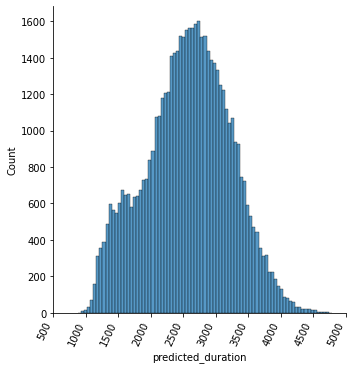

In [ ]:
sns.displot(check_results['predicted_duration']).set_xticklabels(rotation=65, horizontalalignment='right')

#### 4.1 post-processing

In [ ]:
# As notified: 
# Order lateness / underprediction of delivery time is of
# particular concern as past experiments suggest that underestimating delivery time is roughly twice as costly as
# overestimating it. Orders that are very early / late are also much worse than those that are only slightly early / late

# by eyeball checking the first 5 predictions:
# for example the 5th row will raise concerns: 
# the prediction is 1513.36 seconds (about 25 mins), avg_cook_time is null. 
# predicted duration distribution is different from training actual distribution
# may consider adding average processing time to reduce underestimation if I can have more data.

# may consider adding average processing time to predictions to reduce underestimation if I can have more data.